In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')


In [2]:

# Cargar el dataset principal de solicitudes de adelanto en efectivo
cr = pd.read_csv('../project_dataset/extract - cash request - data analyst.csv')
# Inspeccionar la estructura y el tipo de datos de 'cash_request'
cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          23970 non-null  int64  
 1   amount                      23970 non-null  float64
 2   status                      23970 non-null  object 
 3   created_at                  23970 non-null  object 
 4   updated_at                  23970 non-null  object 
 5   user_id                     21867 non-null  float64
 6   moderated_at                16035 non-null  object 
 7   deleted_account_id          2104 non-null   float64
 8   reimbursement_date          23970 non-null  object 
 9   cash_request_received_date  16289 non-null  object 
 10  money_back_date             16543 non-null  object 
 11  transfer_type               23970 non-null  object 
 12  send_at                     16641 non-null  object 
 13  recovery_status             333

In [3]:
# Crear una copia del DataFrame para preservar el original
credit_requests = cr.copy()

In [4]:
# Cargar el dataset de tarifas o fees para análisis de cohortes de tarifas
fs = pd.read_csv('../project_dataset/extract - fees - data analyst - .csv')
fs.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21061 entries, 0 to 21060
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               21061 non-null  int64  
 1   cash_request_id  21057 non-null  float64
 2   type             21061 non-null  object 
 3   status           21061 non-null  object 
 4   category         2196 non-null   object 
 5   total_amount     21061 non-null  float64
 6   reason           21061 non-null  object 
 7   created_at       21061 non-null  object 
 8   updated_at       21061 non-null  object 
 9   paid_at          15531 non-null  object 
 10  from_date        7766 non-null   object 
 11  to_date          7766 non-null   object 
 12  charge_moment    21061 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 2.1+ MB


In [5]:
# Crear una copia del DataFrame para preservar el original
fees = fs.copy()

rows_with_null_id = fees[fees['cash_request_id'].isnull()]
print(rows_with_null_id)

         id  cash_request_id             type     status category  \
1911   2990              NaN  instant_payment  cancelled      NaN   
1960   3124              NaN  instant_payment  cancelled      NaN   
4605   5185              NaN  instant_payment  cancelled      NaN   
11870  3590              NaN  instant_payment  cancelled      NaN   

       total_amount                              reason  \
1911            5.0  Instant Payment Cash Request 11164   
1960            5.0  Instant Payment Cash Request 11444   
4605            5.0  Instant Payment Cash Request 11788   
11870           5.0  Instant Payment Cash Request 12212   

                          created_at                     updated_at paid_at  \
1911   2020-08-06 22:42:34.525373+00  2020-11-04 16:01:17.296048+00     NaN   
1960   2020-08-08 06:33:06.244651+00  2020-11-04 16:01:08.332978+00     NaN   
4605   2020-08-26 09:39:37.362933+00  2020-11-04 16:01:36.492576+00     NaN   
11870  2020-08-12 14:20:06.657075+00  2020

In [6]:
# Clean `credit_requests`
# Rellenar valores nulos en 'user_id' usando 'deleted_account_id' (clientes transferidos de cuentas eliminadas)
cash_request = credit_requests
cash_request.fillna({"user_id": cash_request["deleted_account_id"]}, inplace=True)

# 2. Estandarización de formatos
# Convert datetime columns to pandas datetime
datetime_columns = ['created_at', 'updated_at', 'moderated_at', 'reimbursement_date', 'money_back_date', 'cash_request_received_date', 'send_at', 'reco_creation', 'reco_last_update']
for col in datetime_columns:
    cash_request[col] = pd.to_datetime(cash_request[col], errors='coerce')
    cash_request[col] = cash_request[col].dt.tz_localize(None)
    credit_requests[col] = pd.to_datetime(cash_request[col], errors='coerce')
    credit_requests[col] = credit_requests[col].dt.tz_localize(None)

# 5. **Limpieza de datos** Eliminar la columna 'deleted_account_id' ya que no es necesaria después de la imputación
#cash_request.drop(columns=["deleted_account_id"], inplace=True)
cash_request.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23970 entries, 0 to 23969
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          23970 non-null  int64         
 1   amount                      23970 non-null  float64       
 2   status                      23970 non-null  object        
 3   created_at                  23970 non-null  datetime64[ns]
 4   updated_at                  23970 non-null  datetime64[ns]
 5   user_id                     23970 non-null  float64       
 6   moderated_at                15912 non-null  datetime64[ns]
 7   deleted_account_id          2104 non-null   float64       
 8   reimbursement_date          3050 non-null   datetime64[ns]
 9   cash_request_received_date  16289 non-null  datetime64[ns]
 10  money_back_date             12040 non-null  datetime64[ns]
 11  transfer_type               23970 non-null  object    

In [7]:
# 1. Manejo de valores faltantes
# - Impute 'category' with 'Unknown', keep `paid_at`, `from_date`, `to_date` for further filtering
data_cleaned = fees.copy()
data_cleaned['category'] = data_cleaned['category'].fillna('Unknown')

# 2. Estandarización de formatos
# Convert datetime columns to pandas datetime
datetime_columns = ['created_at', 'updated_at', 'paid_at', 'from_date', 'to_date']
for col in datetime_columns:
    data_cleaned[col] = pd.to_datetime(data_cleaned[col], errors='coerce')
    data_cleaned[col] = data_cleaned[col].dt.tz_localize(None)
    fees[col] = pd.to_datetime(fees[col], errors='coerce')
    fees[col] = fees[col].dt.tz_localize(None)
    
# Standardize column names
data_cleaned.columns = data_cleaned.columns.str.lower().str.replace(' ', '_')

# Resultado final
display(data_cleaned.info())
data_cleaned.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21061 entries, 0 to 21060
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               21061 non-null  int64         
 1   cash_request_id  21057 non-null  float64       
 2   type             21061 non-null  object        
 3   status           21061 non-null  object        
 4   category         21061 non-null  object        
 5   total_amount     21061 non-null  float64       
 6   reason           21061 non-null  object        
 7   created_at       21061 non-null  datetime64[ns]
 8   updated_at       21061 non-null  datetime64[ns]
 9   paid_at          15438 non-null  datetime64[ns]
 10  from_date        6749 non-null   datetime64[ns]
 11  to_date          6512 non-null   datetime64[ns]
 12  charge_moment    21061 non-null  object        
dtypes: datetime64[ns](5), float64(2), int64(1), object(5)
memory usage: 2.1+ MB


None

,id,cash_request_id,type,status,category,total_amount,reason,created_at,updated_at,paid_at,from_date,to_date,charge_moment
0,6537,14941.0,instant_payment,rejected,Unknown,5.0,Instant Payment Cash Request 14941,2020-09-07 10:47:27.423150,2020-10-13 14:25:09.396112,2020-12-17 14:50:07.470110,NaT,NaT,after
1,6961,11714.0,incident,accepted,rejected_direct_debit,5.0,rejected direct debit,2020-09-09 20:51:17.998653,2020-10-13 14:25:15.537063,2020-12-08 17:13:10.459080,NaT,NaT,after
2,16296,23371.0,instant_payment,accepted,Unknown,5.0,Instant Payment Cash Request 23371,2020-10-23 10:10:58.352972,2020-10-23 10:10:58.352994,2020-11-04 19:34:37.432910,NaT,NaT,after
3,20775,26772.0,instant_payment,accepted,Unknown,5.0,Instant Payment Cash Request 26772,2020-10-31 15:46:53.643958,2020-10-31 15:46:53.643982,2020-11-19 05:09:22.500223,NaT,NaT,after
4,11242,19350.0,instant_payment,accepted,Unknown,5.0,Instant Payment Cash Request 19350,2020-10-06 08:20:17.170432,2020-10-13 14:25:03.267983,2020-11-02 14:45:20.355598,NaT,NaT,after


In [8]:
# Merge on `id` and `cash_request_id`
merged_data = pd.merge(
    cash_request,
    fees,
    left_on='id',
    right_on='cash_request_id',
    how='left'
)

print(merged_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32094 entries, 0 to 32093
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id_x                        32094 non-null  int64         
 1   amount                      32094 non-null  float64       
 2   status_x                    32094 non-null  object        
 3   created_at_x                32094 non-null  datetime64[ns]
 4   updated_at_x                32094 non-null  datetime64[ns]
 5   user_id                     32094 non-null  float64       
 6   moderated_at                21530 non-null  datetime64[ns]
 7   deleted_account_id          2573 non-null   float64       
 8   reimbursement_date          4061 non-null   datetime64[ns]
 9   cash_request_received_date  24149 non-null  datetime64[ns]
 10  money_back_date             17204 non-null  datetime64[ns]
 11  transfer_type               32094 non-null  object    

In [9]:
# Average requested amount and fee
print(merged_data['amount'].mean())
print(merged_data['total_amount'].mean())

# Correlation between credit amount and fees
print(merged_data[['amount', 'total_amount']].corr())


83.51651399015392
5.0002374507289735
                amount  total_amount
amount        1.000000     -0.008142
total_amount -0.008142      1.000000


In [10]:
# Total fees by type
fees_by_type = merged_data.groupby('type')['total_amount'].sum()
print(fees_by_type)
fees_by_type = merged_data.groupby('type')['total_amount'].mean()
print(fees_by_type)

# Average fee-to-credit ratio
merged_data['fee_to_credit_ratio'] = merged_data['total_amount'] / merged_data['amount']
avg_ratio = merged_data['fee_to_credit_ratio'].mean()
print(f"Average Fee-to-Credit Ratio: {avg_ratio:.2%}")


type
incident           10980.0
instant_payment    55480.0
postpone           38830.0
Name: total_amount, dtype: float64
type
incident           5.000000
instant_payment    5.000451
postpone           5.000000
Name: total_amount, dtype: float64
Average Fee-to-Credit Ratio: 7.61%


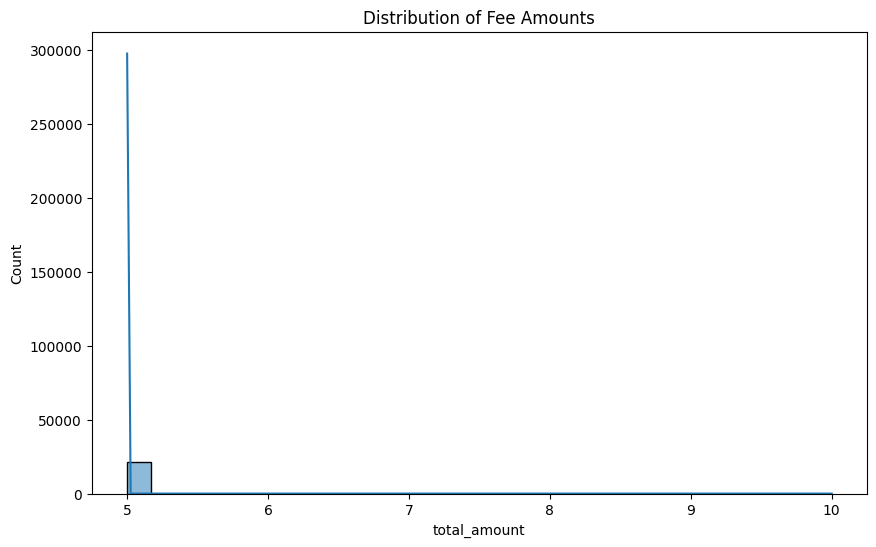

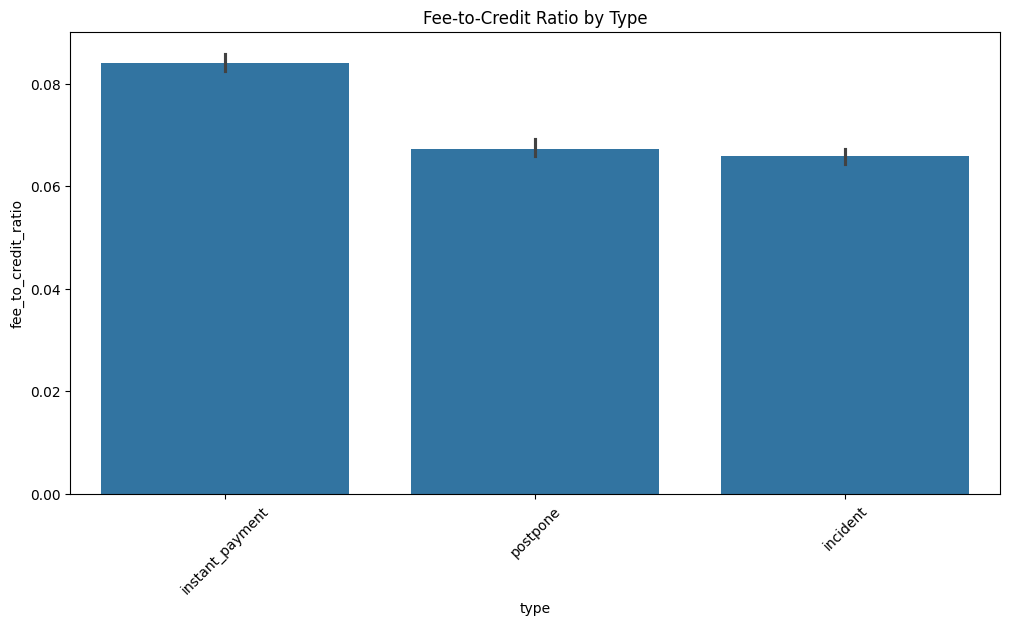

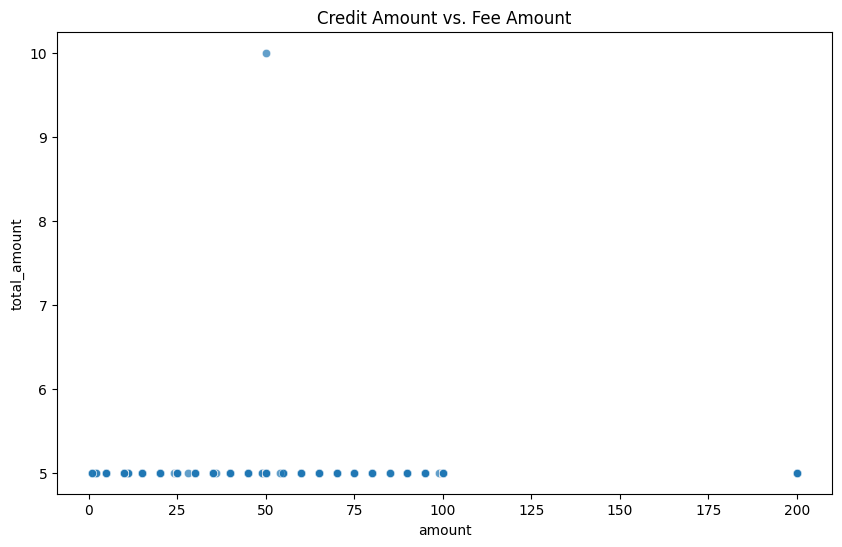

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of Fee Amounts
plt.figure(figsize=(10, 6))
sns.histplot(merged_data['total_amount'], bins=30, kde=True)
plt.title('Distribution of Fee Amounts')
plt.show()

# Fee-to-Credit Ratio by Type
plt.figure(figsize=(12, 6))
sns.barplot(x='type', y='fee_to_credit_ratio', data=merged_data)
plt.title('Fee-to-Credit Ratio by Type')
plt.xticks(rotation=45)
plt.show()

# Credit Amount vs. Fee Amount
plt.figure(figsize=(10, 6))
sns.scatterplot(x='amount', y='total_amount', data=merged_data, alpha=0.7)
plt.title('Credit Amount vs. Fee Amount')
plt.show()


In [12]:
# verify all credit requests have fees

# Perform a left join to ensure all credit requests are included
merged_data2 = pd.merge(
    credit_requests,
    fees,
    left_on='id',
    right_on='cash_request_id',
    how='left'
)
merged_data2.info()
# Check for credit requests without fees
no_fees = merged_data2[merged_data2['total_amount'].isna()]

# Display the result
if no_fees.empty:
    print("All credit requests have fees associated with them.")
else:
    print(f"There are {len(no_fees)} credit requests without fees.")
    print(no_fees[['id_x', 'amount', 'status_x']])  # Display relevant columns for inspection

# Check statuses of credit requests without fees
print(no_fees['status_x'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32094 entries, 0 to 32093
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id_x                        32094 non-null  int64         
 1   amount                      32094 non-null  float64       
 2   status_x                    32094 non-null  object        
 3   created_at_x                32094 non-null  datetime64[ns]
 4   updated_at_x                32094 non-null  datetime64[ns]
 5   user_id                     32094 non-null  float64       
 6   moderated_at                21530 non-null  datetime64[ns]
 7   deleted_account_id          2573 non-null   float64       
 8   reimbursement_date          4061 non-null   datetime64[ns]
 9   cash_request_received_date  24149 non-null  datetime64[ns]
 10  money_back_date             17204 non-null  datetime64[ns]
 11  transfer_type               32094 non-null  object    

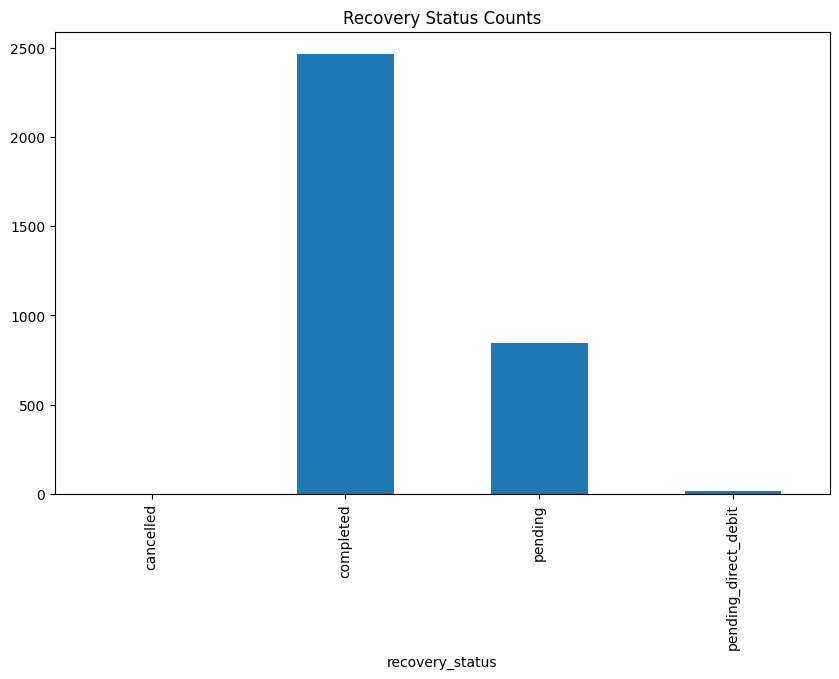

In [13]:
recovery_rates = credit_requests.groupby('recovery_status').size()
recovery_rates.plot(kind='bar', figsize=(10, 6), title='Recovery Status Counts')
plt.show()


In [14]:
missing_by_status = credit_requests.groupby('status').apply(lambda x: x.isnull().sum())
print(missing_by_status)


                       id  amount  status  created_at  updated_at  user_id  \
status                                                                       
active                  0       0       0           0           0        0   
canceled                0       0       0           0           0        0   
direct_debit_rejected   0       0       0           0           0        0   
direct_debit_sent       0       0       0           0           0        0   
money_back              0       0       0           0           0        0   
rejected                0       0       0           0           0        0   
transaction_declined    0       0       0           0           0        0   

                       moderated_at  deleted_account_id  reimbursement_date  \
status                                                                        
active                           37                  59                  58   
canceled                         33                   7     

In [15]:
merged_data.info()

merged_data.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32094 entries, 0 to 32093
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id_x                        32094 non-null  int64         
 1   amount                      32094 non-null  float64       
 2   status_x                    32094 non-null  object        
 3   created_at_x                32094 non-null  datetime64[ns]
 4   updated_at_x                32094 non-null  datetime64[ns]
 5   user_id                     32094 non-null  float64       
 6   moderated_at                21530 non-null  datetime64[ns]
 7   deleted_account_id          2573 non-null   float64       
 8   reimbursement_date          4061 non-null   datetime64[ns]
 9   cash_request_received_date  24149 non-null  datetime64[ns]
 10  money_back_date             17204 non-null  datetime64[ns]
 11  transfer_type               32094 non-null  object    

,id_x,amount,status_x,created_at_x,updated_at_x,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,...,category,total_amount,reason,created_at_y,updated_at_y,paid_at,from_date,to_date,charge_moment,fee_to_credit_ratio
0,5,100.0,rejected,2019-12-10 19:05:21.596873,2019-12-11 16:47:42.407830,804.0,2019-12-11 16:47:42.405646,NaN,2020-01-09 19:05:21.596363,NaT,...,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN,NaN
1,70,100.0,rejected,2019-12-10 19:50:12.347780,2019-12-11 14:24:22.900054,231.0,2019-12-11 14:24:22.897988,NaN,2020-01-09 19:50:12.347780,NaT,...,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN,NaN
2,7,100.0,rejected,2019-12-10 19:13:35.825460,2019-12-11 09:46:59.779773,191.0,2019-12-11 09:46:59.777728,NaN,2020-01-09 19:13:35.825041,NaT,...,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN,NaN
3,10,99.0,rejected,2019-12-10 19:16:10.880172,2019-12-18 14:26:18.136163,761.0,2019-12-18 14:26:18.128407,NaN,2020-01-09 19:16:10.879606,NaT,...,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN,NaN
4,1594,100.0,rejected,2020-05-06 09:59:38.877376,2020-05-07 09:21:55.340080,7686.0,2020-05-07 09:21:55.320193,NaN,NaT,NaT,...,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN,NaN
5,2145,100.0,money_back,2020-05-23 20:58:55.129432,2020-07-06 03:36:03.023911,9489.0,2020-05-24 12:40:33.054910,NaN,NaT,2020-05-26,...,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN,NaN
6,3512,100.0,rejected,2020-06-16 17:07:38.452652,2020-06-17 10:21:21.364746,14631.0,2020-06-17 10:21:21.360742,NaN,NaT,NaT,...,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN,NaN
7,654,100.0,rejected,2020-02-10 01:11:53.808270,2020-02-10 11:53:32.104131,309.0,2020-02-10 09:11:21.350695,309.0,2020-03-11 01:11:53.807930,NaT,...,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN,NaN
8,5672,100.0,canceled,2020-06-28 12:06:33.712840,2020-06-28 12:06:33.712853,2499.0,NaT,2499.0,NaT,NaT,...,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN,NaN
9,71,90.0,rejected,2019-12-10 19:51:23.911206,2019-12-12 15:06:11.192888,897.0,2019-12-12 15:06:11.190299,NaN,2019-12-17 19:51:23.910748,NaT,...,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaN,NaN


In [16]:

# credit requests without fees

# Identify credit requests without a corresponding fee
credit_requests_without_fees = credit_requests[~credit_requests['id'].isin(fees['cash_request_id'])]

# Check the shape and preview
print(f"Number of credit requests without corresponding fees: {credit_requests_without_fees.shape[0]}")
credit_requests_without_fees.head()
credit_requests_without_fees.info()


Number of credit requests without corresponding fees: 11037
<class 'pandas.core.frame.DataFrame'>
Index: 11037 entries, 0 to 23955
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          11037 non-null  int64         
 1   amount                      11037 non-null  float64       
 2   status                      11037 non-null  object        
 3   created_at                  11037 non-null  datetime64[ns]
 4   updated_at                  11037 non-null  datetime64[ns]
 5   user_id                     11037 non-null  float64       
 6   moderated_at                10415 non-null  datetime64[ns]
 7   deleted_account_id          1667 non-null   float64       
 8   reimbursement_date          1770 non-null   datetime64[ns]
 9   cash_request_received_date  4386 non-null   datetime64[ns]
 10  money_back_date             2446 non-null   datetime64[ns]
 11 

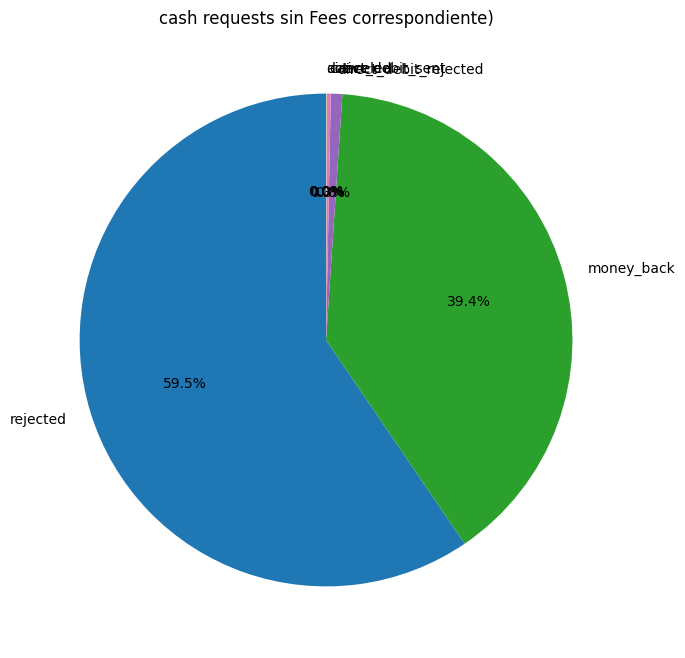

In [17]:
import matplotlib.pyplot as plt

# Count the occurrences of each 'status' value
status_counts = credit_requests_without_fees['status'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 8))
status_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colormap='tab20', legend=False)

# Formatting the chart
plt.title('cash requests sin Fees correspondiente)')
plt.ylabel('')  # Remove y-axis label for cleaner look
plt.show()


In [18]:
# Count the occurrences of each 'status' value
status_counts = credit_requests_without_fees['status'].value_counts()

# Convert to a DataFrame for better readability
status_counts_table = status_counts.reset_index()
status_counts_table.columns = ['Status', 'Count']

# Display the table
print(status_counts_table)


                  Status  Count
0               rejected   6568
1             money_back   4352
2  direct_debit_rejected     83
3               canceled     29
4                 active      3
5      direct_debit_sent      2


In [19]:
# Check for duplicate IDs
duplicate_ids = credit_requests[credit_requests['id'].duplicated(keep=False)]

# Count the number of duplicate IDs
num_duplicates = duplicate_ids['id'].nunique()

# Display results
print(f"Number of duplicate IDs: {num_duplicates}")
if num_duplicates > 0:
    print("Sample duplicate entries:")
    print(duplicate_ids.sort_values(by='id').head())
else:
    print("No duplicate IDs found.")


Number of duplicate IDs: 0
No duplicate IDs found.


In [20]:
# Get distinct values in the 'reason' column
distinct_reasons = fees['reason'].unique()

# Display the distinct values
print(f"Distinct values in 'reason' column ({len(distinct_reasons)} unique values):")

i=0
for reason in distinct_reasons:
    print(f"- {reason}")
    i+=1
    if i > 20:
        break;


Distinct values in 'reason' column (15149 unique values):
- Instant Payment Cash Request 14941
- rejected direct debit
- Instant Payment Cash Request 23371
- Instant Payment Cash Request 26772
- Instant Payment Cash Request 19350
- Instant Payment Cash Request 24052
- Instant Payment Cash Request 25983
- Instant Payment Cash Request 26572
- Postpone Cash Request 22106
- Instant Payment Cash Request 24756
- Postpone Cash Request 21897
- Postpone Cash Request 25490
- Instant Payment Cash Request 26568
- Instant Payment Cash Request 25902
- Instant Payment Cash Request 26565
- Postpone Cash Request 19876
- Instant Payment Cash Request 22136
- Postpone Cash Request 24564
- Instant Payment Cash Request 25527
- Postpone Cash Request 19909
- Postpone Cash Request 22357


In [21]:
reason_counts = fees['cash_request_id'].value_counts()
#print(reason_counts)

# Filter to include only reasons with a count greater than 1
reason_counts_filtered = reason_counts[reason_counts > 1]

# Display the filtered counts
#print("Distinct 'reason' counts greater than 1:")
#print(reason_counts_filtered)

In [22]:
reason_counts = fees['reason'].value_counts()
print(reason_counts)

# Filter to include only reasons with a count greater than 1
reason_counts_filtered = reason_counts[reason_counts > 1]

# Display the filtered counts
print("Distinct 'reason' counts greater than 1:")
print(reason_counts_filtered)


reason
rejected direct debit                 1599
month delay on payment - 9/2020        283
month delay on payment - 8/2020        203
month delay on payment - 10/2020       102
Postpone Cash Request 12225             34
                                      ... 
Instant Payment Cash Request 21481       1
Instant Payment Cash Request 21140       1
Instant Payment Cash Request 25010       1
Postpone Cash Request 16749              1
Instant Payment Cash Request 20982       1
Name: count, Length: 15149, dtype: int64
Distinct 'reason' counts greater than 1:
reason
rejected direct debit               1599
month delay on payment - 9/2020      283
month delay on payment - 8/2020      203
month delay on payment - 10/2020     102
Postpone Cash Request 12225           34
                                    ... 
Postpone Cash Request 7967             2
Postpone Cash Request 13498            2
Postpone Cash Request 22042            2
Postpone Cash Request 9345             2
Postpone Cash Request

In [23]:
# Create a new column with the first 20 characters of the 'reason' column
fees['reason_truncated'] = fees['reason'].str[:22]

# Count occurrences of each truncated reason
reason_counts = fees['reason_truncated'].value_counts()

# Display the counts
print("Distinct 'reason' counts (based on first 20 characters):")
print(reason_counts)


Distinct 'reason' counts (based on first 20 characters):
reason_truncated
Instant Payment Cash R    11099
Postpone Cash Request      7766
rejected direct debit      1599
month delay on payment      597
Name: count, dtype: int64


In [24]:
fees.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21061 entries, 0 to 21060
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                21061 non-null  int64         
 1   cash_request_id   21057 non-null  float64       
 2   type              21061 non-null  object        
 3   status            21061 non-null  object        
 4   category          2196 non-null   object        
 5   total_amount      21061 non-null  float64       
 6   reason            21061 non-null  object        
 7   created_at        21061 non-null  datetime64[ns]
 8   updated_at        21061 non-null  datetime64[ns]
 9   paid_at           15438 non-null  datetime64[ns]
 10  from_date         6749 non-null   datetime64[ns]
 11  to_date           6512 non-null   datetime64[ns]
 12  charge_moment     21061 non-null  object        
 13  reason_truncated  21061 non-null  object        
dtypes: datetime64[ns](5), 

In [25]:
# Count the occurrences of each cash_request_id
cash_request_id_counts = fees['cash_request_id'].value_counts()

# Display the counts in descending order
print("Cuenta de filas en fees por cada cash_request_id (orden descendiente):")
print(cash_request_id_counts.head(50))


Cuenta de filas en fees por cada cash_request_id (orden descendiente):
cash_request_id
12225.0    35
5006.0     28
4410.0     24
12452.0    23
11376.0    21
2358.0     19
11746.0    17
15319.0    16
4956.0     15
8713.0     15
11968.0    15
11585.0    15
11277.0    14
18264.0    14
17793.0    14
3759.0     13
11658.0    13
15105.0    13
10880.0    12
6727.0     12
2396.0     12
24025.0    12
8202.0     12
18785.0    12
6717.0     12
2211.0     12
19849.0    11
9541.0     11
6712.0     11
18194.0    11
12627.0    11
11719.0    10
12126.0    10
10436.0    10
13820.0    10
2641.0     10
6982.0     10
14282.0    10
16716.0    10
13516.0    10
16023.0    10
16319.0    10
13324.0    10
2346.0     10
6625.0     10
15312.0    10
3676.0     10
5019.0     10
4981.0     10
13072.0     9
Name: count, dtype: int64


3. **Identificación de posibles errores**: Esto implica buscar valores atípicos, anomalías o datos que no tienen sentido dentro delcontexto delconjunto de datos.Los errores pueden manifestarse de diversas formas,como valores extremadamente altos o bajos que no son representativos del resto de los datos, o datos que violan las restricciones lógicas de un dominio específico.

In [26]:
    # Filter rows where fees total_amount > 5
    filtered_rows = fees[fees['total_amount'] > 5]
    
    # Check if any rows are found
    if filtered_rows.empty:
        print(f"No rows found where cash_request_id is empty.")
    else:
        # Sort the filtered rows by 'updated_at' column
        filtered_rows_sorted = filtered_rows.sort_values(by='created_at')
    
        # Display the sorted rows
        print(f"Rows where total_amount > 5, ordered by updated_at:")
        print(filtered_rows_sorted[['cash_request_id', 'reason', 'total_amount']])
        filtered_rows_cr = cash_request[cash_request['id'] == 22799]
        print(filtered_rows_cr[['id', 'amount']])


Rows where total_amount > 5, ordered by updated_at:
       cash_request_id                              reason  total_amount
20604          22799.0  Instant Payment Cash Request 22799          10.0
          id  amount
23689  22799    50.0


**fees con total_amount = 10**: Possible error puesto que el resto de total_amount son 5 para el resto de cash_request

In [27]:

value_to_filter = 12225.0,  5006, 4410, 12452, 11376  # Example value

for  i in value_to_filter:
    # Filter rows where cash_request_id matches the specified value
    filtered_rows = fees[fees['cash_request_id'] == i]
    
    # Check if any rows are found
    if filtered_rows.empty:
        print(f"No rows found where cash_request_id is {value_to_filter}.")
    else:
        # Sort the filtered rows by 'updated_at' column
        filtered_rows_sorted = filtered_rows.sort_values(by='created_at')
    
        # Display the sorted rows
        print(f"Rows where cash_request_id is {i}, ordered by created_at:")
        print(filtered_rows_sorted[['reason', 'paid_at']])
        #print(filtered_rows_sorted[['id','cash_request_id','reason','total_amount', 'paid_at', 'created_at','updated_at', 'from_date','to_date']])



Rows where cash_request_id is 12225.0, ordered by created_at:
                                   reason                    paid_at
8764   Instant Payment Cash Request 12225 2020-10-02 11:27:24.787458
17389         Postpone Cash Request 12225                        NaT
17390         Postpone Cash Request 12225                        NaT
17391         Postpone Cash Request 12225                        NaT
17392         Postpone Cash Request 12225                        NaT
17381         Postpone Cash Request 12225                        NaT
17393         Postpone Cash Request 12225                        NaT
17394         Postpone Cash Request 12225                        NaT
17395         Postpone Cash Request 12225                        NaT
17396         Postpone Cash Request 12225                        NaT
2958          Postpone Cash Request 12225 2020-08-29 13:54:31.574311
18153         Postpone Cash Request 12225                        NaT
18154         Postpone Cash Request 12225

- vemos varios ejemplso de cash_request_id donde hay multiples filas de fees para 1 transacción debido a peticiones de posponer pago
- columna 'reason'



['total_amount']


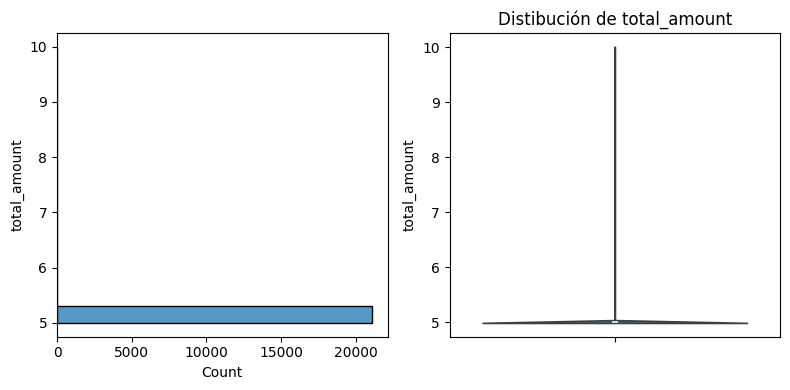

In [28]:
columnas_numericas = ['total_amount']
print(columnas_numericas)

for c in columnas_numericas:
    if fees[c].dtype.kind != 'M':
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        sns.violinplot(y=c, data=fees, ax=axs[1])
        sns.histplot(y=c, data=fees, ax=axs[0])
        plt.title(f'Distibución de {c}')
        plt.tight_layout()
        plt.show()

- como explicado, outlier de 10 de total_amount como fee para un cash_request de 50 para cash_request_id=22799

type
instant_payment    11099
postpone            7766
incident            2196
Name: count, dtype: int64

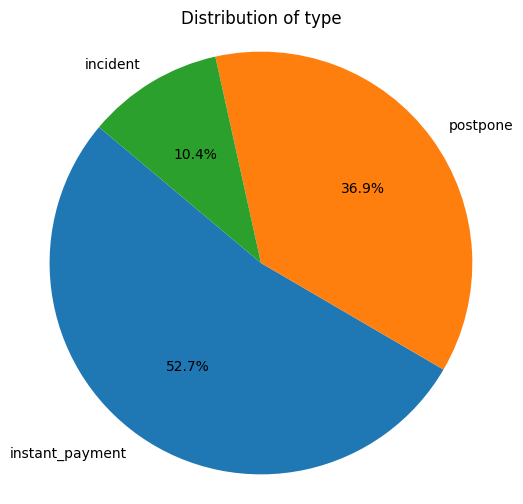

status
accepted     14841
cancelled     4938
rejected      1194
confirmed       88
Name: count, dtype: int64

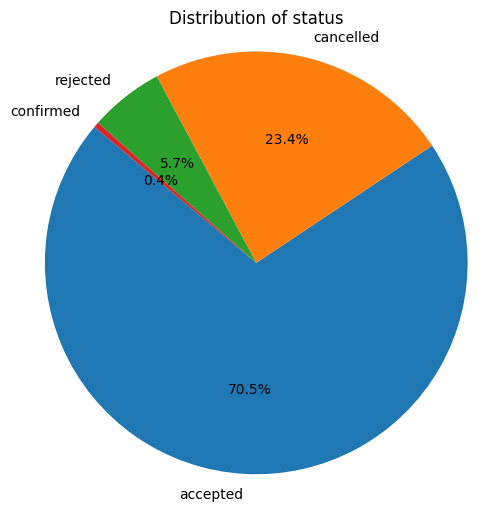

category
rejected_direct_debit     1599
month_delay_on_payment     597
Name: count, dtype: int64

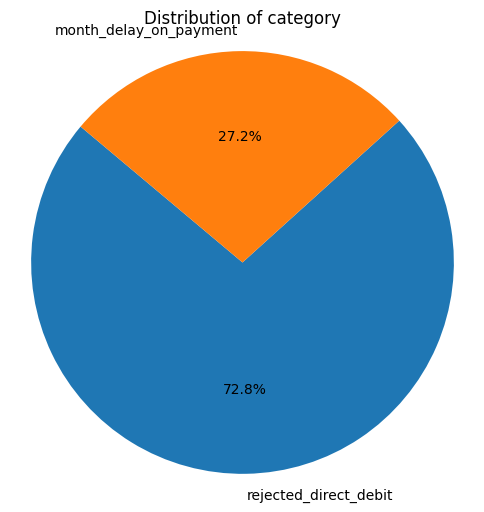

total_amount
5.0     21060
10.0        1
Name: count, dtype: int64

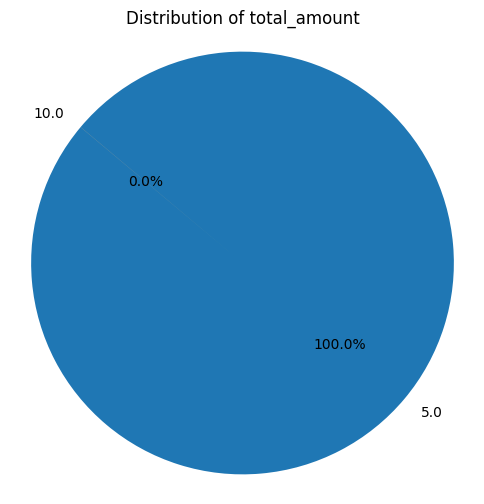

reason
rejected direct debit               1599
month delay on payment - 9/2020      283
month delay on payment - 8/2020      203
month delay on payment - 10/2020     102
Postpone Cash Request 12225           34
Postpone Cash Request 5006            25
Postpone Cash Request 4410            23
Name: count, dtype: int64

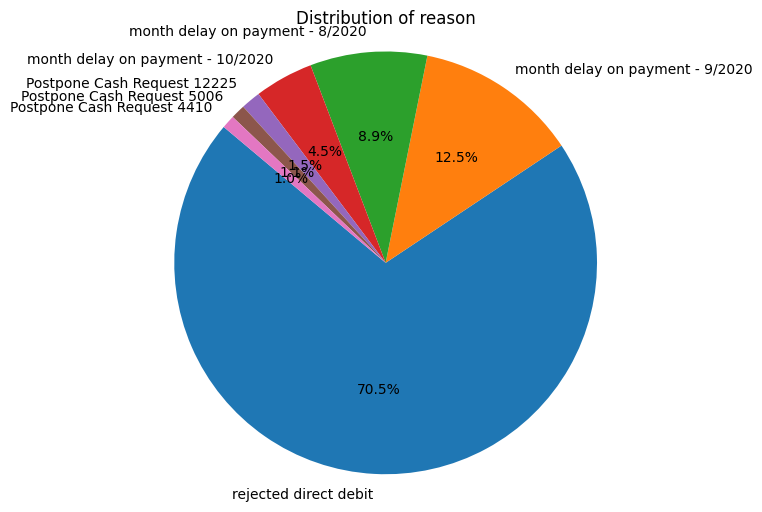

charge_moment
after     16724
before     4337
Name: count, dtype: int64

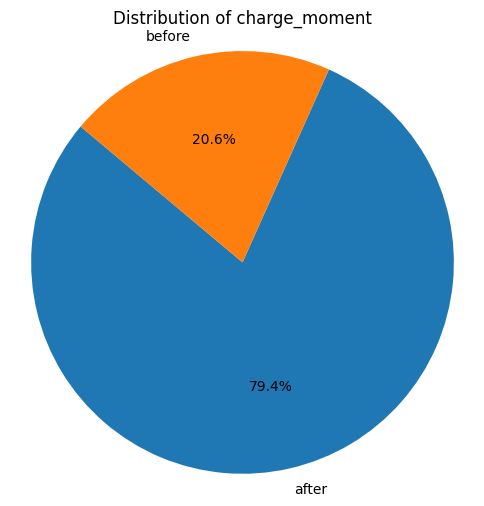

reason_truncated
Instant Payment Cash R    11099
Postpone Cash Request      7766
rejected direct debit      1599
month delay on payment      597
Name: count, dtype: int64

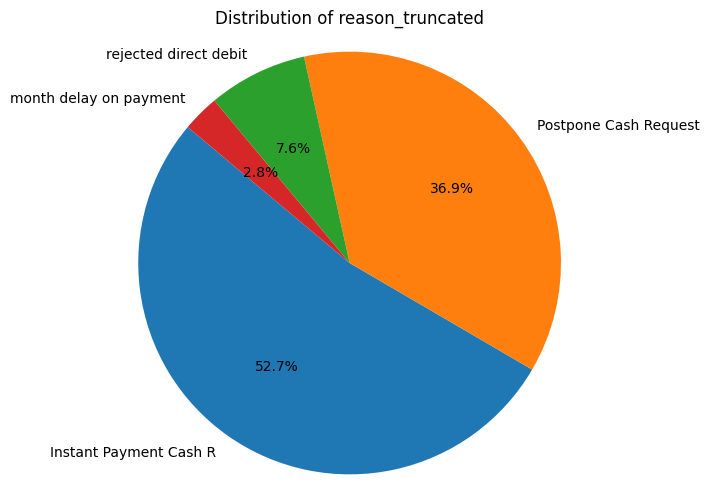

In [29]:
columns_to_plt = ['type', 'status', 'category', 'total_amount', 'reason', 'charge_moment', 'reason_truncated'] 
for c in columns_to_plt:
    reason_counts = fees[c].value_counts().head(7)
    display(reason_counts.head(7))
    # Create a pie plot using Seaborn for the 'status' column
    plt.figure(figsize=(6, 6))
    plt.title(f'Distribution of {c}')
    plt.legend = True
    plt.pie(reason_counts, labels=reason_counts.index.tolist(), autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()


### 3.2 Resumen del Análisis Exploratorio de Datos (AED)

El análisis exploratorio de datos (AED) es la brújula que nos guía a través del vasto territorio de nuestros conjuntos de datos.Nos sumerge en la riqueza de la información,revelando patrones,
tendencias y anomalías que pueden pasar desapercibidas a simple vista.Desde la distribución de calificaciones hasta la correlación entre variables,el AED nos proporciona una comprensión profunda de nuestros datos y nos ayuda a formular hipótesis valiosas para análisis posteriores.

#### 3.2.2 Componentes del AED:

1. **Exploración de Datos Univariable**: Análisis de una variable a la vez para comprender su distribución y estadísticas descriptivas.Este enfoque nos permite entender la naturaleza de cada variable y cómo se distribuyen en el conjunto de datos.
2. **Exploración de Datos Bivariable**: Análisis de la relación entre dos variables para identificar posibles asociaciones o correlaciones.Este análisis nos ayuda a comprender las interacciones entre diferentes variables y su impacto en los resultados.
3. **Identificación de Valores Atípicos**: Detección de puntos que se desvían significativamente de la tendencia general de los datos.La identificación de valores atípicos nos permite comprender mejor la distribución de los datos y evaluar su influencia en nuestros análisis.

### 3.3 Insights de Calidad de Datos 

La calidad de los datos es la piedra angular de cualquier análisis significativo.Los datos incompletos,incorrectos o inconsistentes pueden socavar la validez de nuestros resultados y conducir a conclusiones erróneas.Por lo tanto, es crucial realizar una evaluación rigurosa de la calidad de los datos y tomar medidas para abordar cualquier problema identificado.

#### 3.3.2 Estrategias de Mejora de Calidad de Datos:

1. **Limpieza de Datos**: Identificación y corrección de errores, valores atípicos y datos faltantes.
La limpieza de datos es un proceso esencialpara garantizar la integridad y la precisión de nuestros análisis.
2. **Validación de Datos**: Verificación de la precisión y consistencia de los datos mediante técnicas como la validación cruzada.La validación de datos nos ayuda a confirmar la calidad de nuestros datos y a identificar posibles problemas.
3. **Actualización Regular**: Mantenimiento constante de la integridad de los datos mediante actualizaciones periódicas y revisión continua.La actualización regular de los datos garantiza que estén actualizados y reflejen con precisión la realidad en curso.

### 3.4 Resultados del Análisis de Cohortes 

El análisis de cohortes es una herramienta poderosa para comprender cómo se comportan grupos de individuos a lo largo del tiempo.Al dividir a los usuarios en cohortes basadas en ciertos criterios
(por ejemplo, fecha de inscripción), podemos rastrear su comportamiento y evaluar el impacto de diferentes factores en su experiencia.

#### 3.4.2 Beneficios del Análisis de Cohortes:

1. **Identificación de Tendencias a Largo Plazo**: Permite observar cómo cambian los comportamientos a lo largo del tiempo.El análisis de cohortes nos proporciona una visión a largo plazo de la evolución del comportamiento de los usuarios.
2. **Comparación entre Grupos Homogéneos**: Facilita la comparación de diferentes cohortes con características similares.Esto nos ayuda a comprender mejor las diferencias en elcomportamiento de los usuarios y a identificar áreas de mejora.
3. **Evaluación del Impacto de Intervenciones**: Ayuda a evaluar el efecto de cambios o intervenciones en la experiencia delusuario. El análisis de cohortes nos permite medir el impacto de nuestras acciones y ajustar nuestras estrategias en consecuencia.

['id_x', 'amount', 'created_at_x', 'updated_at_x', 'user_id', 'moderated_at', 'deleted_account_id', 'reimbursement_date', 'cash_request_received_date', 'money_back_date', 'send_at', 'reco_creation', 'reco_last_update', 'id_y', 'cash_request_id', 'total_amount', 'created_at_y', 'updated_at_y', 'paid_at', 'from_date', 'to_date', 'fee_to_credit_ratio']
Gráfico de dispersión de amount vs paid_at


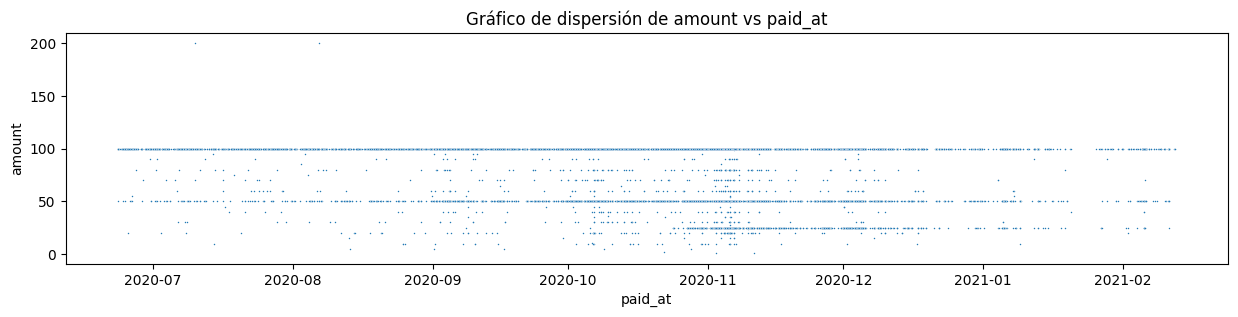

In [30]:
# Genera gráficos de dispersión para todas las combinaciones de columnas numéricas

columnas_numericas=merged_data.describe().columns.tolist()
print(merged_data.describe().columns.tolist())
columnas_numericas = ['amount','paid_at']
for c1, c2 in itertools.combinations(columnas_numericas, 2):
    print(f'Gráfico de dispersión de {c1} vs {c2}')
    plt.figure(figsize=(15, 3))
    plt.title(f'Gráfico de dispersión de {c1} vs {c2}')
    if merged_data[c1].dtype.kind != 'M' and merged_data[c2].dtype.kind == 'M':
        t = c1
        c1 = c2
        c2 = t
    sns.scatterplot(data=merged_data, x=c1, y=c2, marker='.', s=5)
    if merged_data[c1].dtype.kind != 'M' and merged_data[c2].dtype.kind != 'M':
        z = np.polyfit(merged_data[c1], merged_data[c2], 1)
        p = np.poly1d(z)
        plt.plot(merged_data[c1],p(merged_data[c1]),"r--")
        # plt.hexbin(data=data, x=c1, y=c2, gridsize=30, cmap='Blues')

    plt.show()

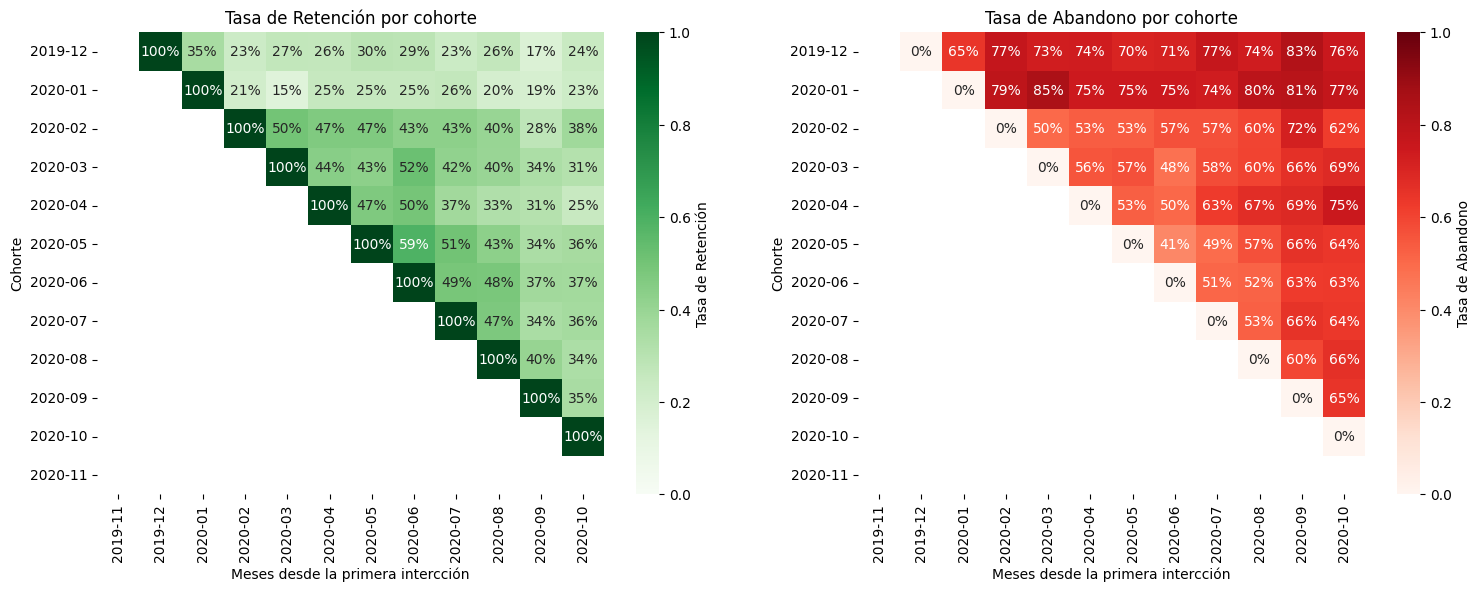

In [31]:
def retention_rate_monthly(cr, field_id, field_date, delete_last=True, title='por cohorte'):
    # Crear columna 'Mes' indicando el mes de cada intercción
    cr['Mes'] = cr[field_date].dt.to_period('M')
    # Crear columna 'Cohorte' que indica el mes de la primera intercción de cada id
    cr['Cohorte'] = cr.groupby(field_id)[field_date].transform('min').dt.to_period('M')
    # Calcular el número inicial de field_id únicos en cada cohorte
    cohort_sizes_initial = cr.groupby('Cohorte').agg(Num_id_Iniciales=(field_id, 'nunique')).reset_index()
    # Calcular la cantidad de field_id únicos en cada cohorte para cada mes
    cohort_sizes_monthly = cr.groupby(['Cohorte', 'Mes']).agg(Num_id=(field_id, 'nunique')).reset_index()
    # Calcular la tasa de retención de field_id (field_id únicos por cohorte en cada mes / field_id iniciales de la cohorte) 
    retention = cohort_sizes_monthly.pivot(index='Cohorte', columns='Mes',values='Num_id')
    retention = retention.div(cohort_sizes_initial.set_index('Cohorte')['Num_id_Iniciales'], axis=0)
    retention = retention.iloc[1:, :-1] if delete_last else retention
    # Calcular la tasa de abandono de field_id (1 - tasa de retención)
    churn = 1 - retention

    if retention.empty:
        print(f'No existen registros para {field_id} '+ title)
        return 0

    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    # Visualizar la tasa de retención de field_id usando un mapa de calor
    axs[0].set_title(f'Tasa de Retención ' + title)
    sns.heatmap(data=retention, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='Greens', cbar_kws={'label': 'Tasa de Retención'}, ax=axs[0])
    axs[0].set_xlabel('Meses desde la primera intercción')
    axs[0].set_ylabel('Cohorte')

    # Visualizar la tasa de abandono de field_id usando un mapa de calor
    axs[1].set_title(f'Tasa de Abandono ' + title)
    sns.heatmap(data=churn, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='Reds', cbar_kws={'label': 'Tasa de Abandono'}, ax=axs[1])
    axs[1].set_xlabel('Meses desde la primera intercción')
    axs[1].set_ylabel('Cohorte')
    plt.show()

retention_rate_monthly(merged_data.copy(), 'user_id', 'created_at_x')

In [32]:
def retention_rate_solicit_monthly(cr, field_id, field_date, delete_last=True, title='por cohorte'):

    # Crear columna 'Mes' indicando el mes de cada intercción
    cr['Mes'] = cr[field_date].dt.to_period('M')
    # Crear columna 'Cohorte' que indica el mes de la primera intercción de cada id
    cr['Cohorte'] = cr.groupby(field_id)[field_date].transform('min').dt.to_period('M')
    # Calcular la cantidad de solicitudes de adelanto de efectivo de los clientes de cada cohorte en cada mes
    cohort_cash_monthly = cr.groupby(['Cohorte', 'Mes']).agg(Num_Solicitudes=(field_id, 'count')).reset_index()
    # Calcular el número inicial de solicitudes de adelanto de efectivo en cada cohorte
    cohort_cash_initial = cohort_cash_monthly.groupby('Cohorte').first().reset_index().rename(columns={'Num_Solicitudes':'Num_Solicitudes_Iniciales'})
    # Calcular la tasa de retención de solicitudes (solicitudes por cohorte en cada mes / solicitudes iniciales de la cohorte)
    retention_cash = cohort_cash_monthly.pivot(index='Cohorte', columns='Mes',values='Num_Solicitudes')
    retention_cash = retention_cash.div(cohort_cash_initial.set_index('Cohorte')['Num_Solicitudes_Iniciales'], axis=0)
    retention_cash = retention_cash.iloc[1:, :-1] if delete_last else retention_cash

    # Calcular la tasa de abandono de solicitudes (1 - tasa de retención de solicitudes)
    churn_cash = 1 - retention_cash

    if retention_cash.empty:
        print(f'No existen registros para {field_id} '+ title)
        return 0
        
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    # Visualizar la tasa de retención de solicitudes usando un mapa de calor
    axs[0].set_title('Tasa de Retención aditiva '+title)
    sns.heatmap(data=retention_cash, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='Blues', cbar_kws={'label': 'Tasa de Retención'}, ax=axs[0])
    axs[0].set_xlabel('Meses desde la primera solicitud de adelanto en efectivo')
    axs[0].set_ylabel('Cohorte')

    # Visualizar la tasa de abandono de solicitudes usando un mapa de calor
    axs[1].set_title('Tasa de Abandono aditiva '+title)
    sns.heatmap(data=churn_cash, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='Oranges', cbar_kws={'label': 'Tasa de Abandono'}, ax=axs[1])
    axs[1].set_xlabel('Meses desde la primera solicitud de adelanto en efectivo')
    axs[1].set_ylabel('Cohorte')
    plt.show()

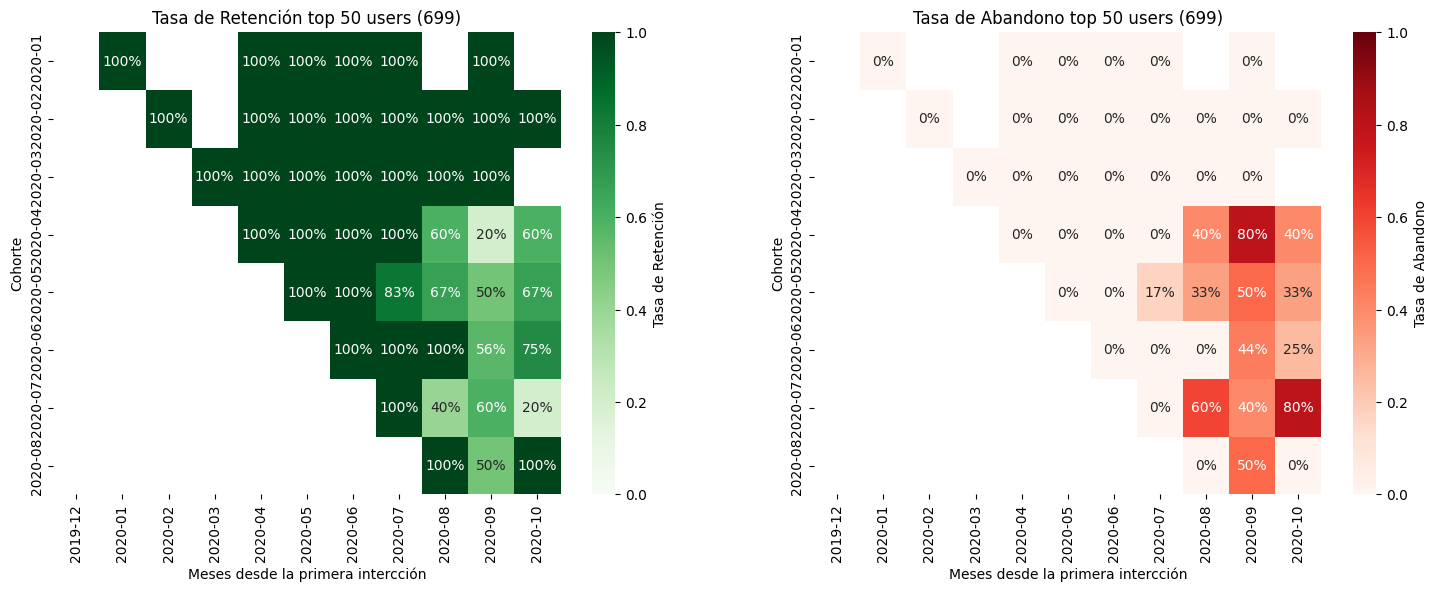

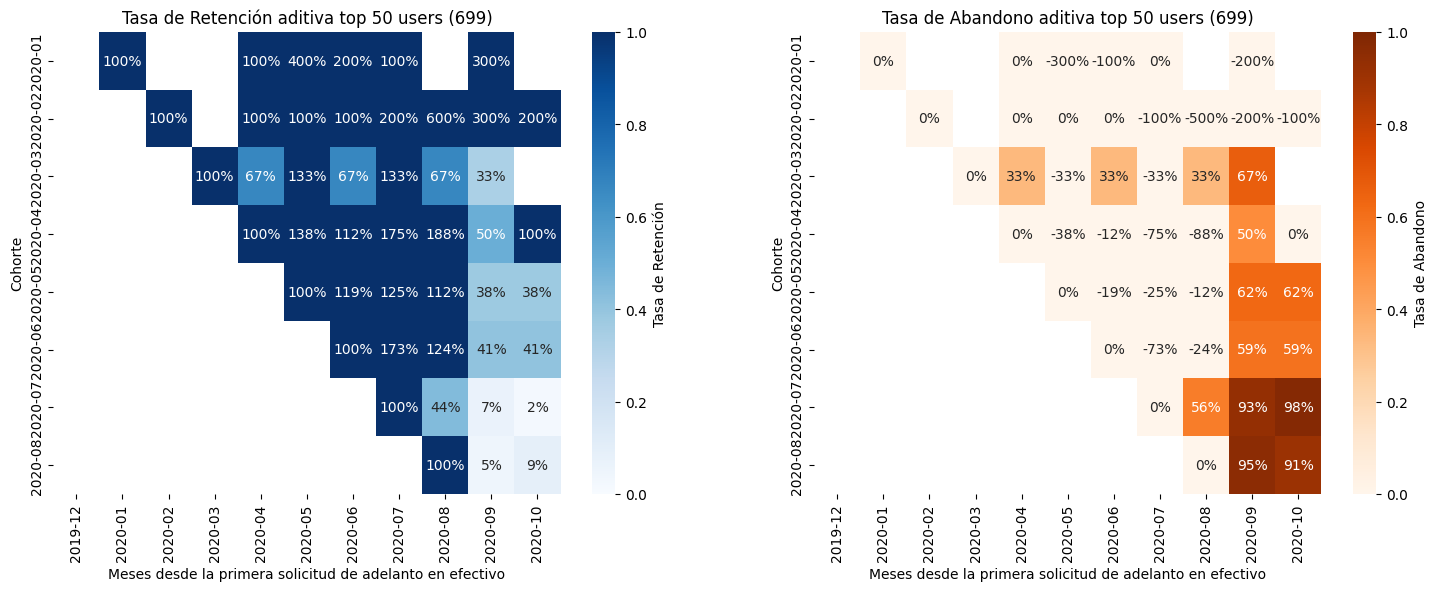

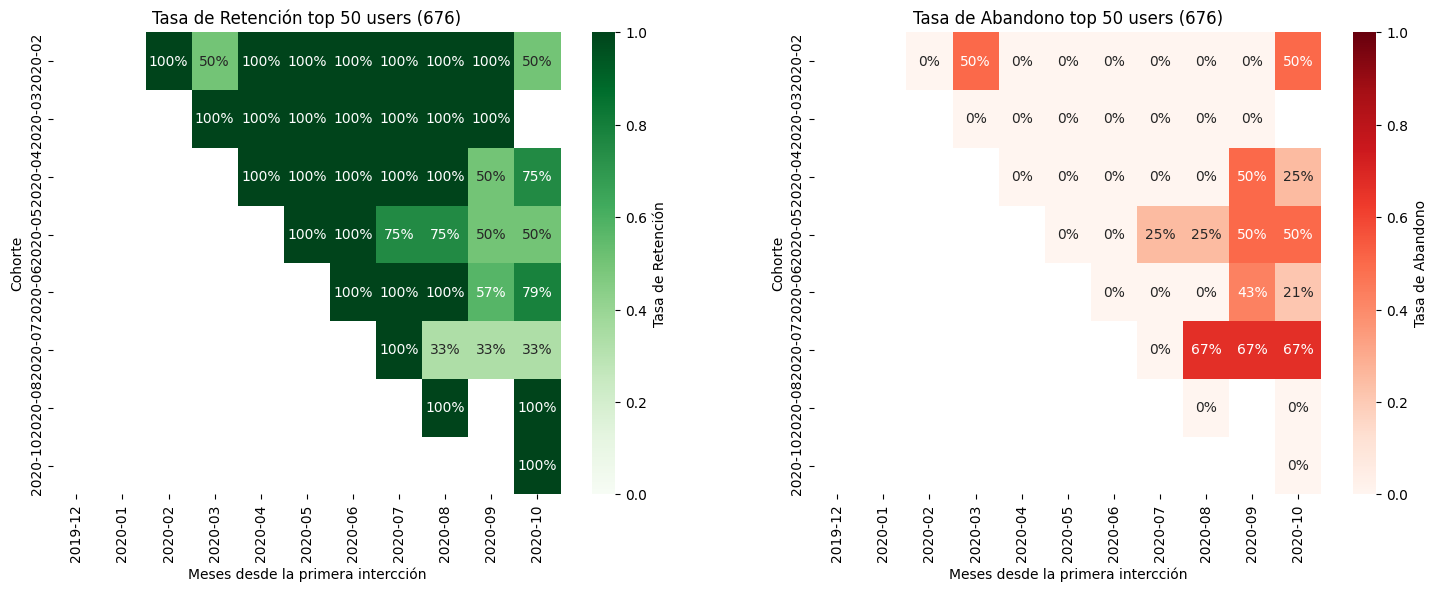

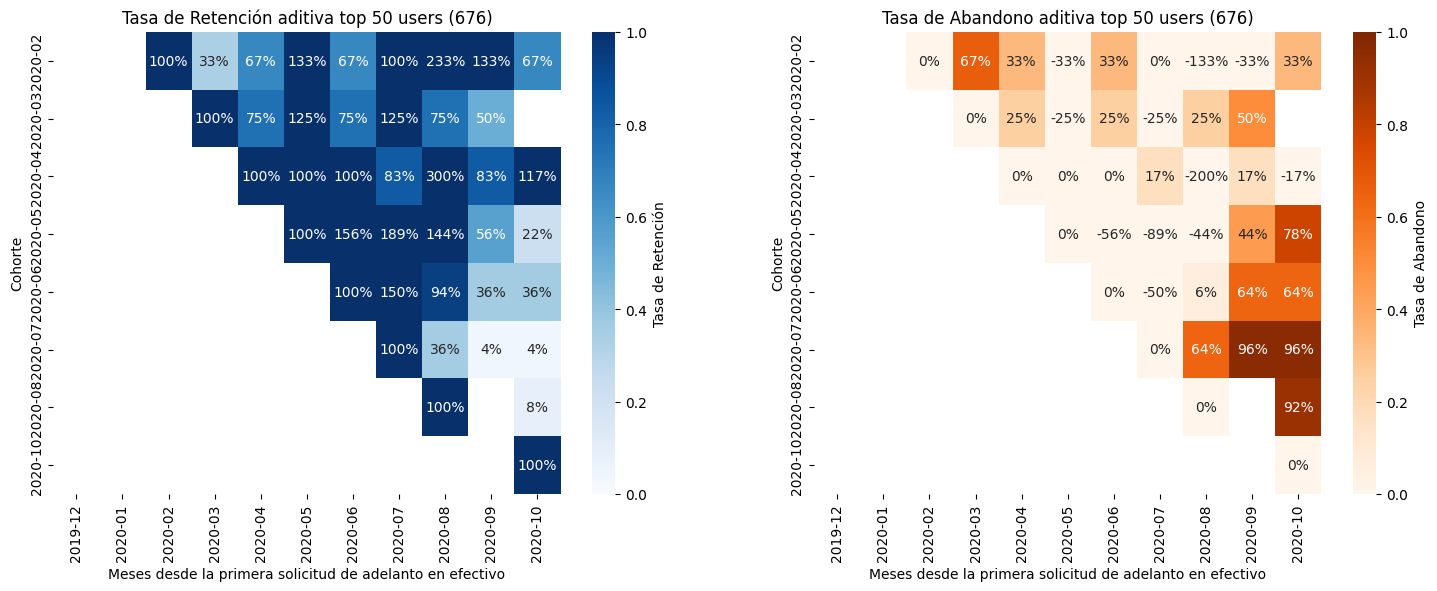

In [33]:

# Analizar tasa de retención de clientes más activos
ntop = 50

# Buscar clientes con alta retención 
data = cash_request.copy()

top_cr_users = data.groupby('user_id').count().sort_values(by='created_at',ascending=False).reset_index().head(ntop)['user_id'].tolist()
top_amount_users = data.groupby('user_id').sum('amount').reset_index().sort_values(by='amount',ascending=False).head(ntop)['user_id']

top_cr_users = data[data['user_id'].isin(top_cr_users)].copy()
top_amount_users = data[data['user_id'].isin(top_amount_users)].copy()

retention_rate_monthly(top_cr_users, 'user_id', 'created_at', title=f'top {ntop} users ({len(top_cr_users)})')
retention_rate_solicit_monthly(top_cr_users, 'user_id', 'created_at', title=f'top {ntop} users ({len(top_cr_users)})')
retention_rate_monthly(top_amount_users, 'user_id', 'created_at', title=f'top {ntop} users ({len(top_amount_users)})')
retention_rate_solicit_monthly(top_amount_users, 'user_id', 'created_at', title=f'top {ntop} users ({len(top_amount_users)})')

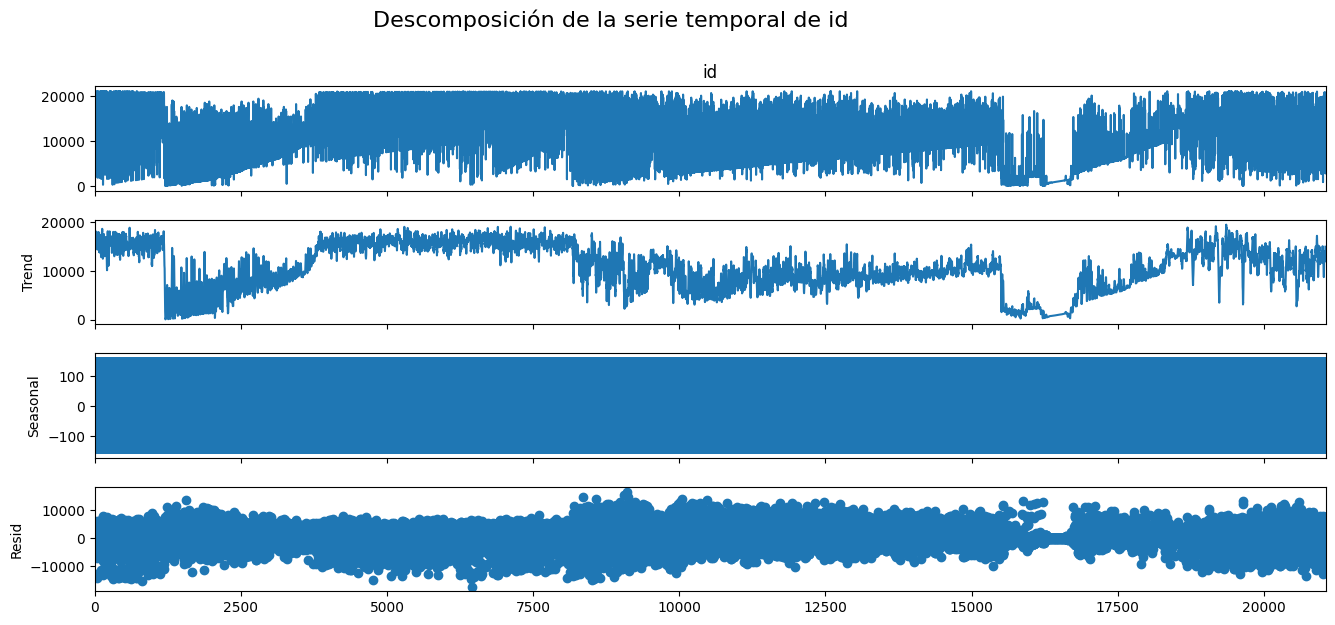

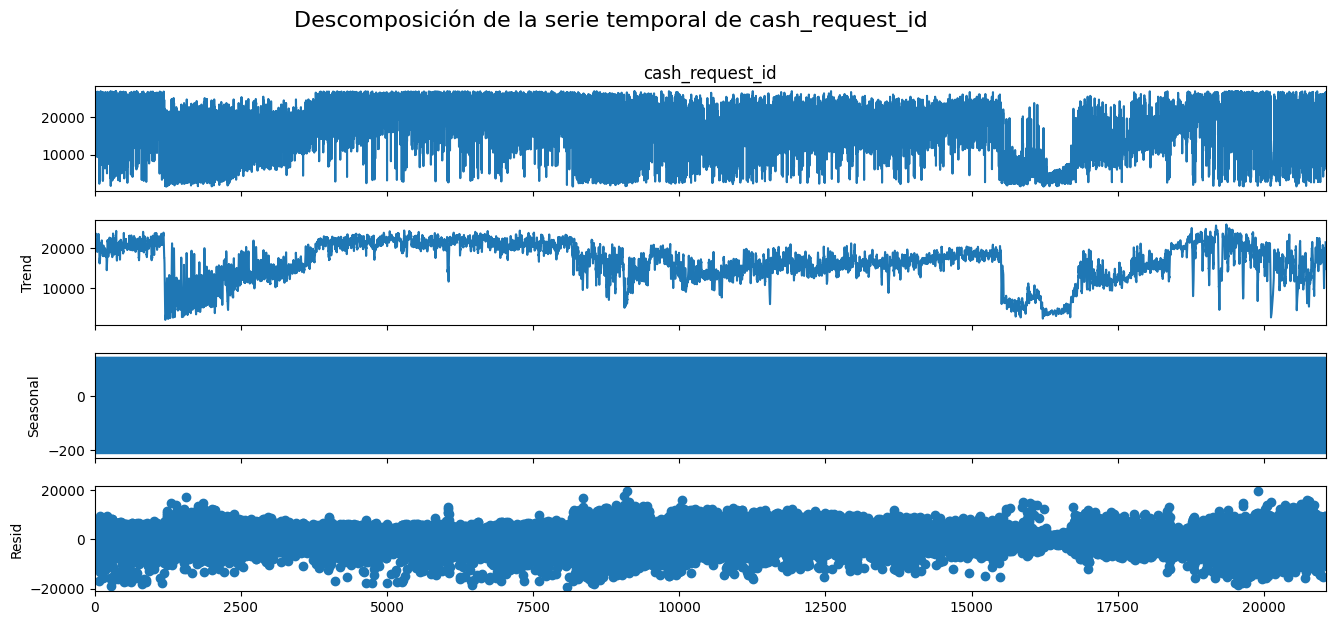

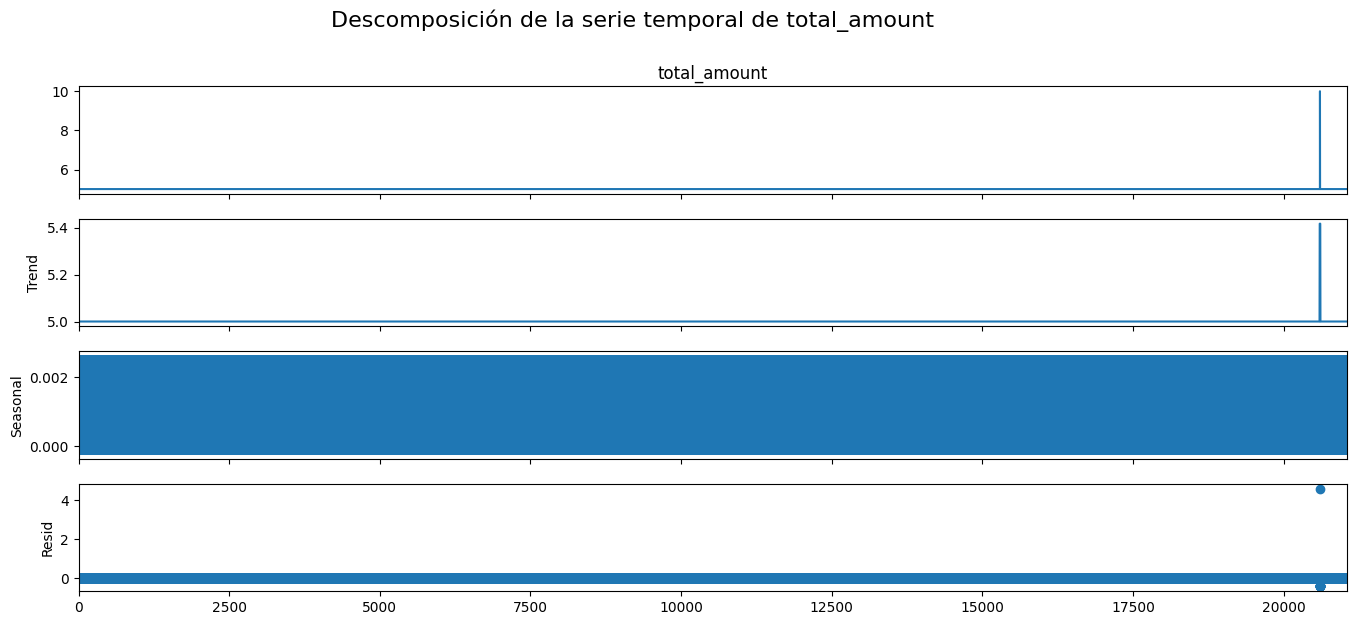

In [34]:
# Descomposición de series temporales para cada columna numérica individual

columnas_numericas=fees.describe().columns.tolist()
for c in columnas_numericas:
    if fees[c].dtype.kind != 'M':
        # Crear una copia del DataFrame para trabajar
        data_copy = fees[c].copy()
        # Verifica si hay valores faltantes y elimínalos o interpola
        if data_copy.isnull().any():
            data_copy = data_copy.interpolate() # Rellenar NaN con interpolación
        # Eliminar filas con valores faltantes
        data_copy = data_copy.dropna()
        # Verificar que no hay valores no finitos
        if not np.isfinite(data_copy).all():
            print(f'La columna {c} contiene valores no finitos, se omite la descomposición.')
            continue
        # Descomposición de la serie temporal
        descomposicion = seasonal_decompose(data_copy, model='additive', period=12)
        # Graficar la descomposición
        fig = descomposicion.plot()
        # Ajustar el tamaño de la figura con matplotlib
        plt.gcf().set_size_inches(15, 6)
        # Ajustar el título para que no se superponga
        fig.suptitle(f'Descomposición de la serie temporal de {c}', fontsize=16, y=1.05)
        plt.show()

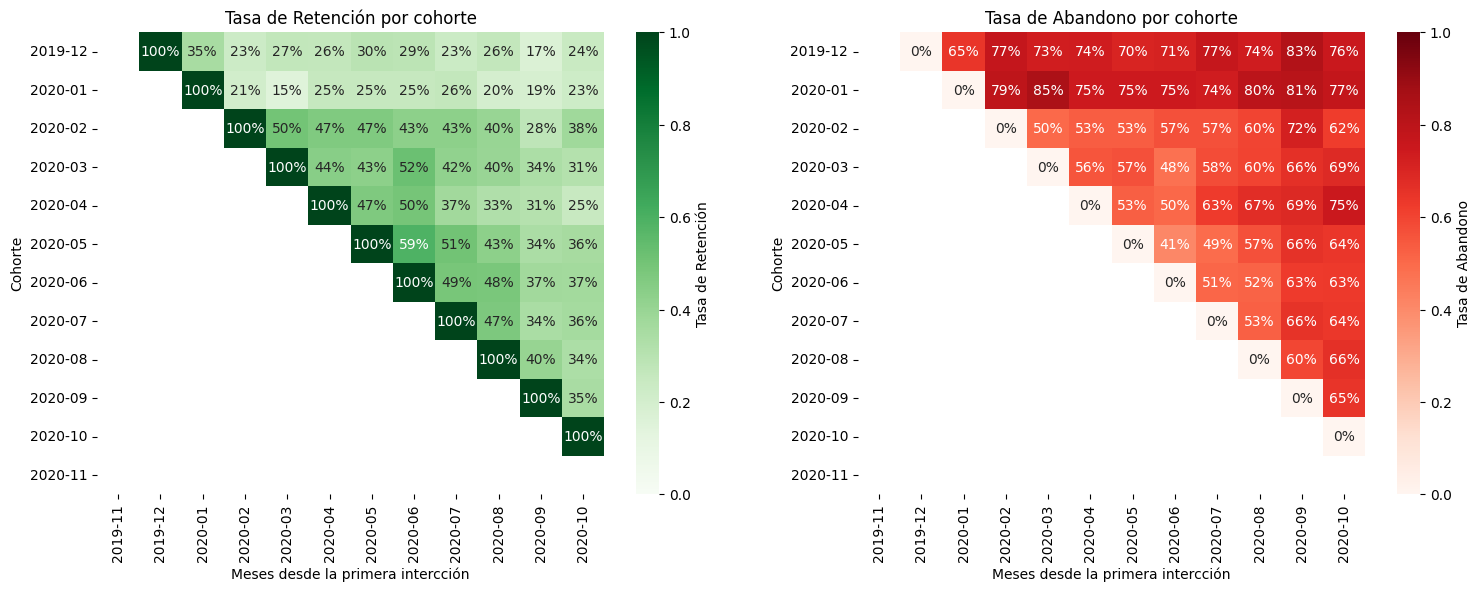

In [35]:
def retention_rate_monthly(cr, field_id, field_date, delete_last=True, title='por cohorte'):
    # Crear columna 'Mes' indicando el mes de cada intercción
    cr['Mes'] = cr[field_date].dt.to_period('M')
    # Crear columna 'Cohorte' que indica el mes de la primera intercción de cada id
    cr['Cohorte'] = cr.groupby(field_id)[field_date].transform('min').dt.to_period('M')
    # Calcular el número inicial de field_id únicos en cada cohorte
    cohort_sizes_initial = cr.groupby('Cohorte').agg(Num_id_Iniciales=(field_id, 'nunique')).reset_index()
    # Calcular la cantidad de field_id únicos en cada cohorte para cada mes
    cohort_sizes_monthly = cr.groupby(['Cohorte', 'Mes']).agg(Num_id=(field_id, 'nunique')).reset_index()
    # Calcular la tasa de retención de field_id (field_id únicos por cohorte en cada mes / field_id iniciales de la cohorte) 
    retention = cohort_sizes_monthly.pivot(index='Cohorte', columns='Mes',values='Num_id')
    retention = retention.div(cohort_sizes_initial.set_index('Cohorte')['Num_id_Iniciales'], axis=0)
    retention = retention.iloc[1:, :-1] if delete_last else retention
    # Calcular la tasa de abandono de field_id (1 - tasa de retención)
    churn = 1 - retention

    if retention.empty:
        print(f'No existen registros para {field_id} '+ title)
        return 0

    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    # Visualizar la tasa de retención de field_id usando un mapa de calor
    axs[0].set_title(f'Tasa de Retención ' + title)
    sns.heatmap(data=retention, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='Greens', cbar_kws={'label': 'Tasa de Retención'}, ax=axs[0])
    axs[0].set_xlabel('Meses desde la primera intercción')
    axs[0].set_ylabel('Cohorte')

    # Visualizar la tasa de abandono de field_id usando un mapa de calor
    axs[1].set_title(f'Tasa de Abandono ' + title)
    sns.heatmap(data=churn, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='Reds', cbar_kws={'label': 'Tasa de Abandono'}, ax=axs[1])
    axs[1].set_xlabel('Meses desde la primera intercción')
    axs[1].set_ylabel('Cohorte')
    plt.show()

retention_rate_monthly(merged_data.copy(), 'user_id', 'created_at_x')

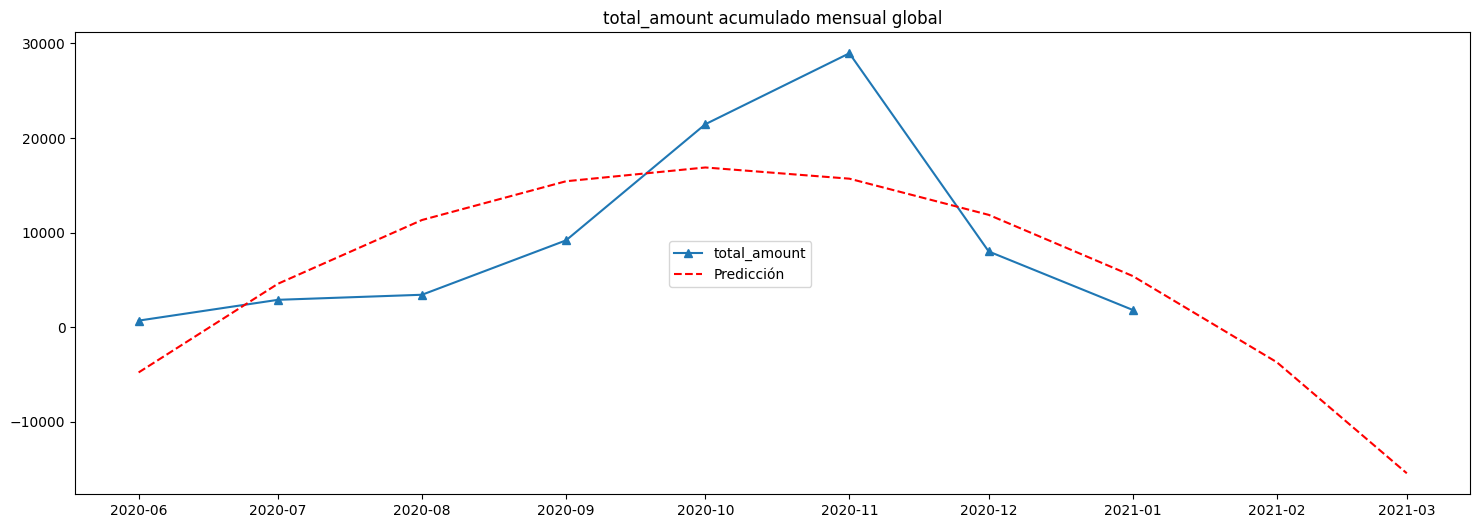

In [36]:
# Dinero total_amount recibido por mes con predicción de tendencia

def monthy_loan(cr, date_field, value_field, poly_degree=2, title='global'):
    cr = cr.groupby(cr[date_field].dt.to_period('M')).sum(value_field)[value_field].reset_index()[:-1]
    cr[date_field] = cr[date_field].dt.to_timestamp()

    # Crea un modelo polinómico de grado 2
    z = np.polyfit(cr.index, cr[value_field], poly_degree)
    p = np.poly1d(z)
    # Encuentra la fecha más grande en el DataFrame
    fecha_max = cr[date_field].max()
    # Genera las dos nuevas fechas correspondientes a los meses siguientes
    nueva_fecha_1 = fecha_max + pd.DateOffset(months=1)
    nueva_fecha_2 = fecha_max + pd.DateOffset(months=2)

    # Crear un DataFrame con las nuevas fechas
    nuevas_fechas = pd.DataFrame({date_field: [nueva_fecha_1, nueva_fecha_2]})

    cr = pd.concat([cr, nuevas_fechas], ignore_index=True)

    # Grafica los datos y la línea polinómica
    fig = plt.figure(figsize=(18,6))
    plt.title(f'{value_field} acumulado mensual ' + title)
    plt.plot(cr[date_field], cr[value_field], label=f'{value_field}', marker='^')
    plt.plot(cr[date_field], p(cr.index), label='Predicción', color='red', linestyle='--')
    fig.legend(loc='center')
    plt.show()

merged_data = merged_data[merged_data['paid_at'].notnull()]
merged_data['paid_at'].dt.to_period('M')
monthy_loan(merged_data.copy(), 'paid_at', 'total_amount')
#monthy_loan(top_cr_users, 'cash_request_received_date', 'amount', title='Top users')


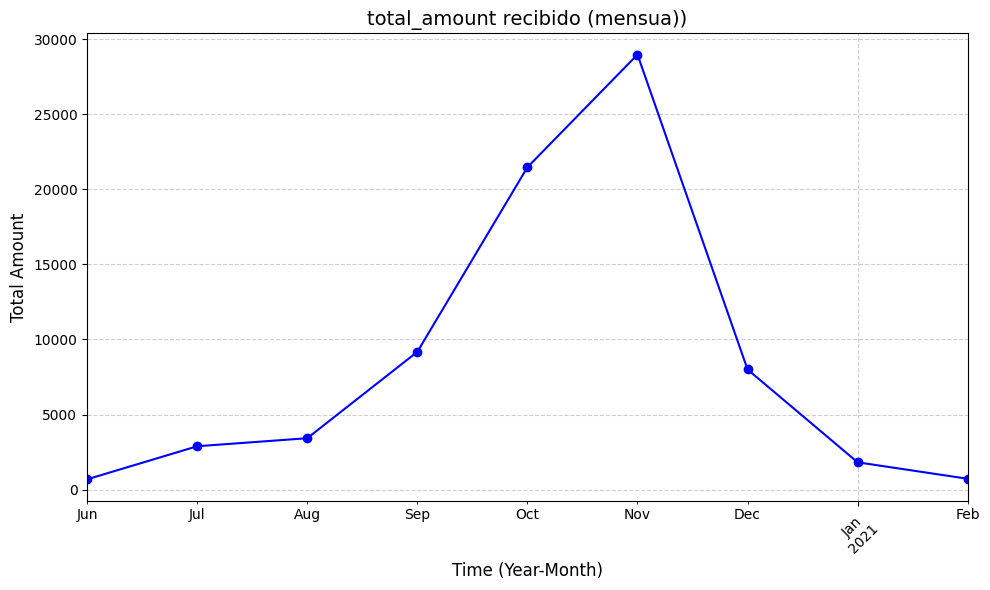

In [37]:
fees_paid = fees[fees['paid_at'].notna()]

# Extract year and month for grouping
fees_paid['year_month'] = fees_paid['paid_at'].dt.to_period('M')

# Group by year_month and sum total_amount
monthly_totals = fees_paid.groupby('year_month')['total_amount'].sum()

# Plotting
plt.figure(figsize=(10, 6))
monthly_totals.plot(kind='line', marker='o', linestyle='-', color='b')
plt.title('total_amount recibido (mensua))', fontsize=14)
plt.xlabel('Time (Year-Month)', fontsize=12)
plt.ylabel('Total Amount', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

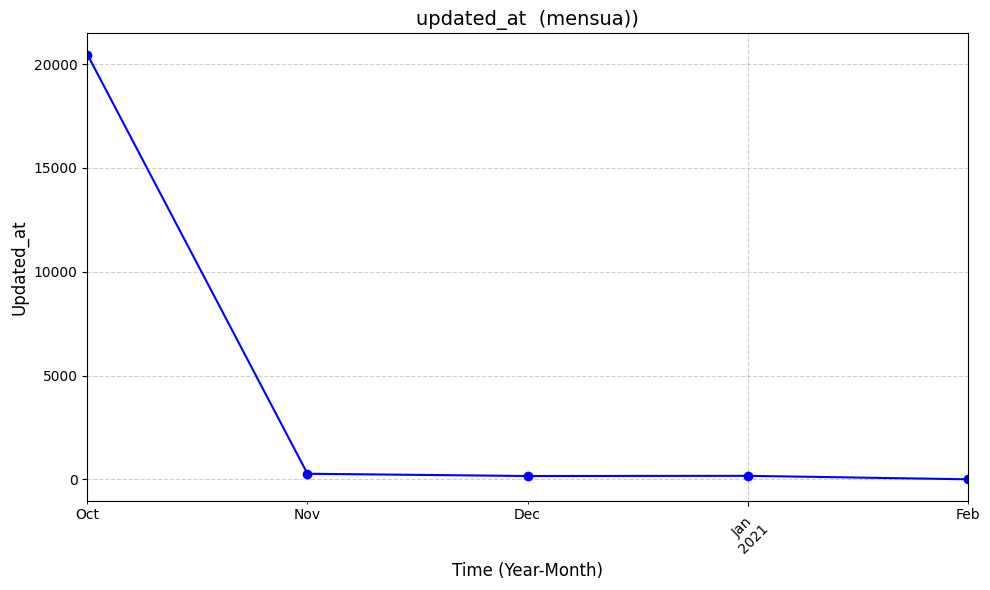

In [43]:

modified_at = fees[fees['updated_at'].notna()]
# Extract year and month for grouping
modified_at['year_month'] = modified_at['updated_at'].dt.to_period('M')

# Group by year_month and sum total_amount
monthly_totals = modified_at.groupby('year_month')['updated_at'].count()

# Plotting
plt.figure(figsize=(10, 6))
monthly_totals.plot(kind='line', marker='o', linestyle='-', color='b')
plt.title('updated_at  (mensua))', fontsize=14)
plt.xlabel('Time (Year-Month)', fontsize=12)
plt.ylabel('Updated_at', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

total_amount únicos con reason_truncated=Instant Payment Cash R: 2 de 11099 reg totales
total_amount en otro registro con reason_truncated = Instant Payment Cash R: 21061


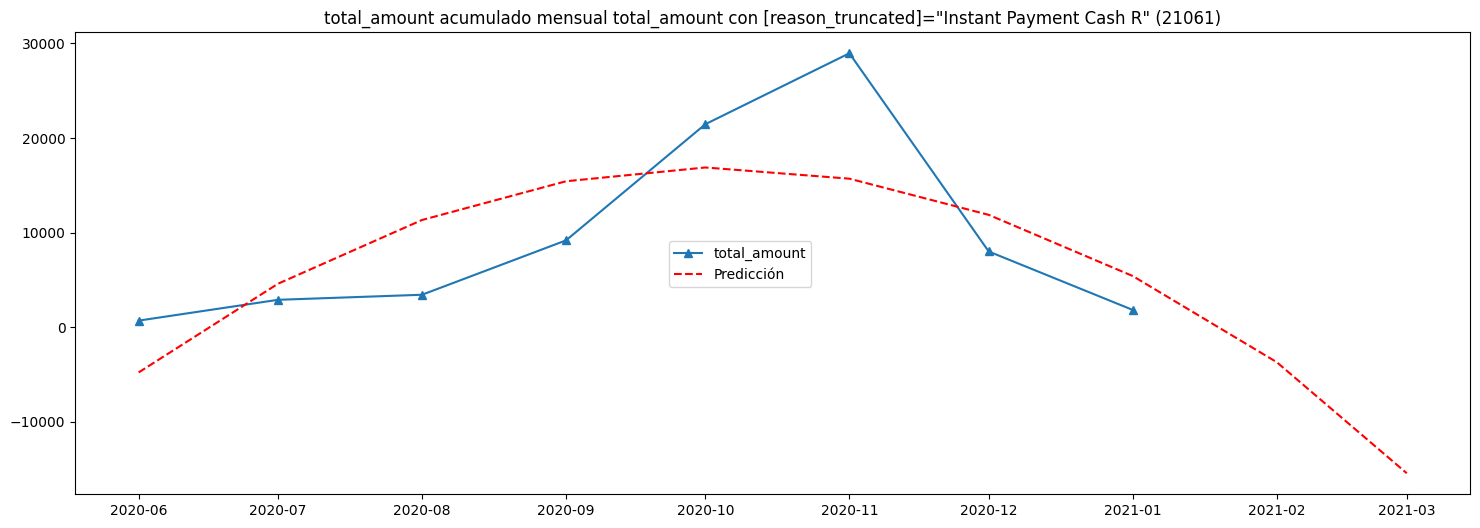

total_amount únicos con reason_truncated=rejected direct debit: 1 de 1599 reg totales
total_amount en otro registro con reason_truncated = rejected direct debit: 21060


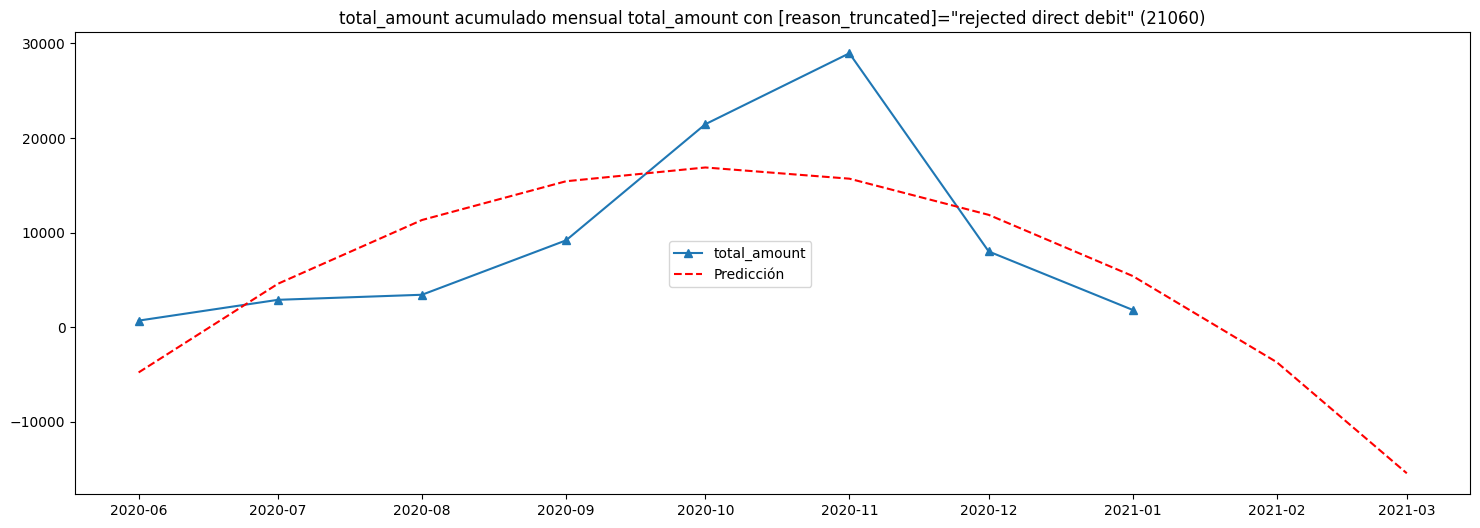

total_amount únicos con reason_truncated=Postpone Cash Request : 1 de 7766 reg totales
total_amount en otro registro con reason_truncated = Postpone Cash Request : 21060


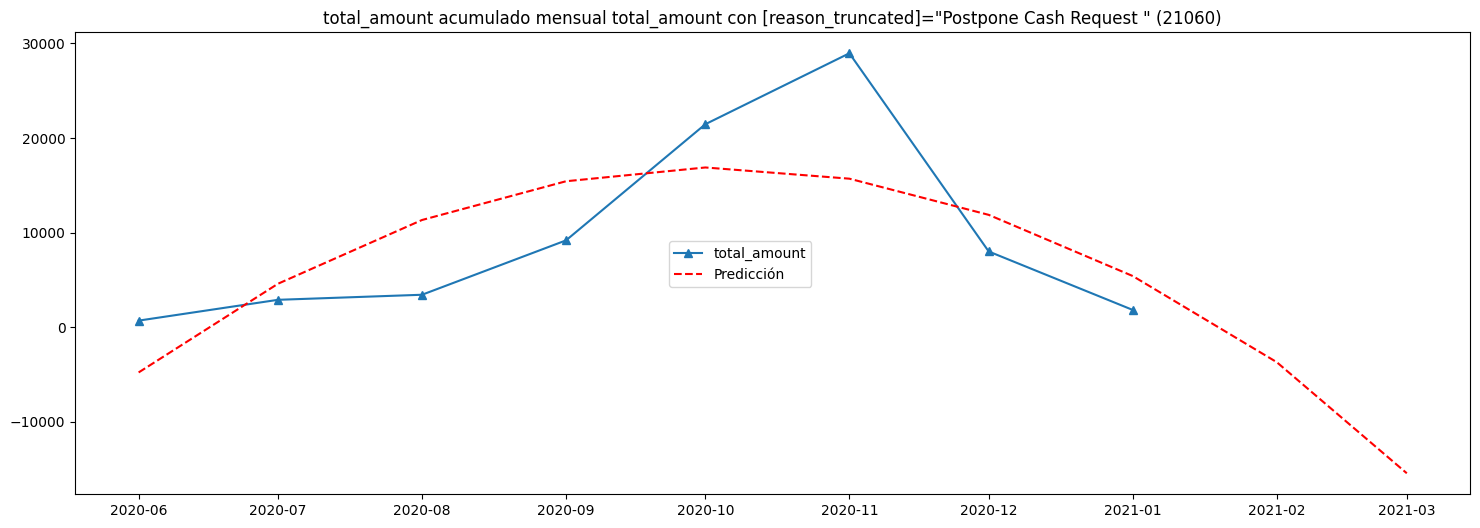

total_amount únicos con reason_truncated=month delay on payment: 1 de 597 reg totales
total_amount en otro registro con reason_truncated = month delay on payment: 21060


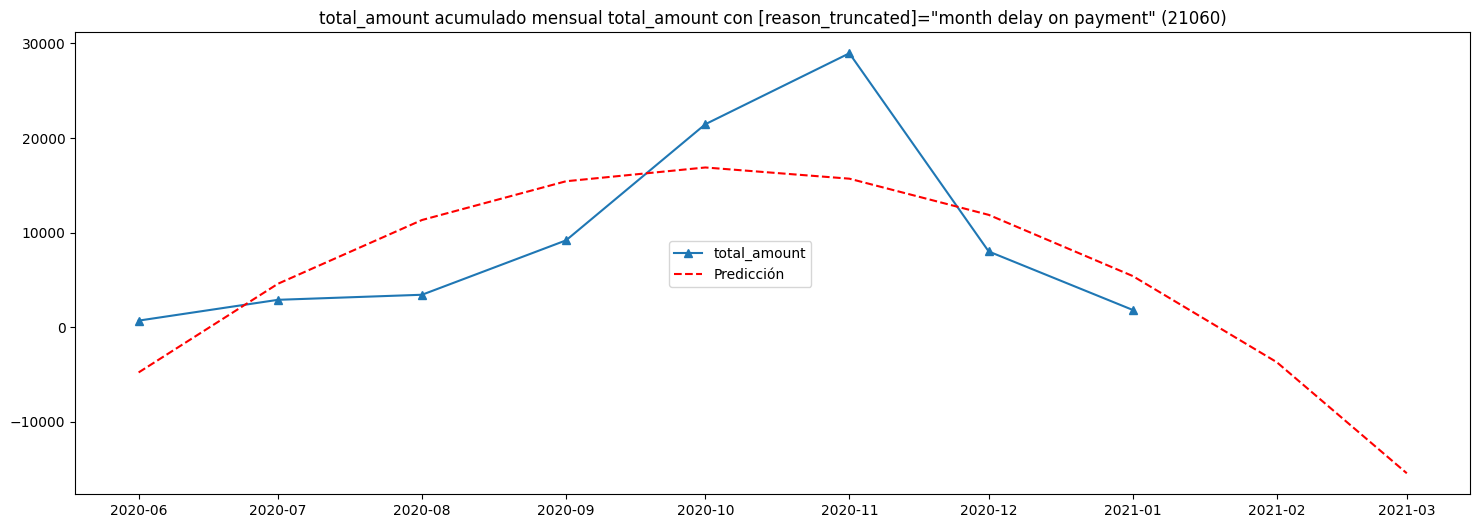

In [38]:
def monthy_loan_field_cohort(df, cohort_column, cohort_value, id_column, date_column, value_field):
    filtered_data = df[df[cohort_column] == cohort_value]
    cohort_id = filtered_data[id_column].unique()
    print(f'{id_column} únicos con {cohort_column}={cohort_value}: {len(cohort_id)} de {len(filtered_data)} reg totales')
    df = df[df[id_column].isin(cohort_id)]
    print(f'{id_column} en otro registro con {cohort_column} = {cohort_value}: {len(df)}')
    if len(df) > 2 :
        monthy_loan(df, date_column, value_field, poly_degree=2, title=f'{id_column} con [{cohort_column}]="{cohort_value}" ({len(df)})')

def monthy_loan_category_cohort(df, cohort_column, id_column, date_column, value_field):
    for cohort_value in df[cohort_column].unique():
        monthy_loan_field_cohort(df, cohort_column, cohort_value, id_column, date_column, value_field)


#for c in merged_data.columns.tolist():
    #if c not in columnas_numericas:
        #monthy_loan_category_cohort(merged_data.copy(), c, 'amount', 'reason', 'total_amount')
monthy_loan_category_cohort(fees.copy(), 'reason_truncated', 'total_amount', 'paid_at', 'total_amount')

      user_id  total_cash_request_amount  total_fees_paid  transaction_count  \
477    6489.0                      800.0             40.0                  8   
2176  21682.0                      750.0             40.0                  8   
1841  18984.0                      700.0             40.0                  8   
456    6219.0                      700.0             35.0                  7   
761    9199.0                      700.0             35.0                  7   
...       ...                        ...              ...                ...   
7599  87458.0                       10.0              5.0                  1   
8674  97197.0                       10.0              5.0                  1   
7631  87698.0                       10.0              5.0                  1   
8268  93036.0                       10.0              5.0                  1   
8454  94767.0                        1.0              5.0                  1   

      category  
477   Platinum  
2176 

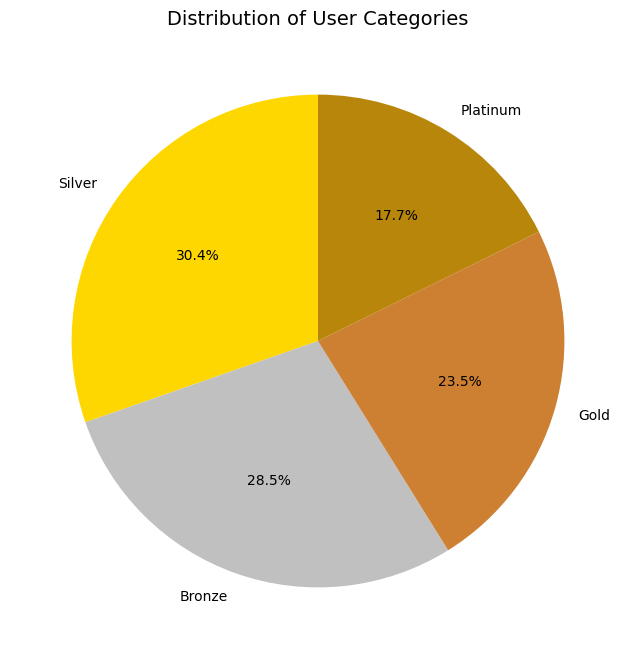

In [39]:
import pandas as pd
import numpy as np

# Filter for paid fees
merged_df_paid = merged_data[merged_data['paid_at'].notna()]

# Aggregate by user_id
user_stats = merged_df_paid.groupby('user_id').agg(
    total_cash_request_amount=('amount', 'sum'),
    total_fees_paid=('total_amount', 'sum'),
    transaction_count=('id_x', 'count')  # Count cash requests
).reset_index()

# Define ranking metric (weighted score)
# Adjust weights (e.g., 0.5, 0.3, 0.2) based on importance
user_stats['ranking_score'] = (
    0.5 * user_stats['total_fees_paid'] +
    0.3 * user_stats['total_cash_request_amount'] +
    0.2 * user_stats['transaction_count']
)

# Sort by ranking score
user_stats = user_stats.sort_values(by='ranking_score', ascending=False)

# Assign categories based on quantiles
quantiles = user_stats['ranking_score'].quantile([0.25, 0.5, 0.75])
user_stats['category'] = pd.cut(
    user_stats['ranking_score'],
    bins=[-np.inf, quantiles[0.25], quantiles[0.5], quantiles[0.75], np.inf],
    labels=['Bronze', 'Silver', 'Gold', 'Platinum']
)

# Result
print(user_stats[['user_id', 'total_cash_request_amount', 'total_fees_paid', 'transaction_count', 'category']])

# Count the number of users in each category
category_counts = user_stats['category'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
category_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#FFD700', '#C0C0C0', '#CD7F32', '#B8860B'])
plt.title('Distribution of User Categories', fontsize=14)
plt.ylabel('')  # Hide the y-label for a cleaner pie chart
plt.show()

